In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.set_figure_params(dpi=150, frameon=False)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
%load_ext autoreload
%autoreload 2

### loading the raw data forb both ref and query

In [5]:
adata = sc.read('./covid_raw_sergey.h5ad')

In [6]:
adata.obs.condition2.value_counts()

control (refrence)           154723
severe COVID-19 (query)       36073
control (query)               19137
moderate COVID-19 (query)      7259
Name: condition2, dtype: int64

In [7]:
adata = adata[~adata.obs['study'].isin(['Villani', 'HCL'])].copy()

In [8]:
adata.obs.study.value_counts()

COVID-19 (query)                     62469
Northwestern_Misharin_2018Reyfman    35447
Sanger_Meyer_2019Madissoon           34407
10X                                  10727
Krasnow_distal 3                     10291
Krasnow_distal 2                      6129
Krasnow_distal 1a                     4675
Krasnow_proximal 3                    4248
Krasnow_medial 2                      3981
Oetjen_U                              3730
Freytag                               3347
Oetjen_P                              3265
Oetjen_A                              2586
Sun_sample4_TC                        2420
Sun_sample3_TB                        2403
Sun_sample2_KC                        2281
Sun_sample1_CS                        1725
Name: study, dtype: int64

In [9]:
sca.add_annotations(adata, '../metadata/c2.cp.reactome.v4.0.symbols.gmt', min_genes=12, clean=False)

In [10]:
adata_raw = adata.copy()

Subsetig the query data 

In [11]:
query = adata[adata.obs['study'].isin(['COVID-19 (query)'])].copy()

In [12]:
adata = adata[~adata.obs['study'].isin(['COVID-19 (query)'])].copy()

In [13]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [14]:
adata.layers["counts"] = adata.X.copy()

In [15]:
sc.pp.normalize_total(adata)

In [16]:
sc.pp.log1p(adata)

In [17]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    batch_key="study",
    subset=True)

Selecting terms with >12 genees

In [18]:
select_terms = adata.varm['I'].sum(0)>12

In [19]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [20]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [21]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [22]:
adata.X = adata.layers["counts"].copy()

In [23]:
adata.obs.study.value_counts()

Northwestern_Misharin_2018Reyfman    35447
Sanger_Meyer_2019Madissoon           34407
10X                                  10727
Krasnow_distal 3                     10291
Krasnow_distal 2                      6129
Krasnow_distal 1a                     4675
Krasnow_proximal 3                    4248
Krasnow_medial 2                      3981
Oetjen_U                              3730
Freytag                               3347
Oetjen_P                              3265
Oetjen_A                              2586
Sun_sample4_TC                        2420
Sun_sample3_TB                        2403
Sun_sample2_KC                        2281
Sun_sample1_CS                        1725
Name: study, dtype: int64

In [24]:
adata.obs.condition2

P1_3_TAAGAGAGTGAAGGCT_Krasnow-0-0-1-1-0-2-0    control (refrence)
P2_1_CTACCCAAGATAGCAT_Krasnow-0-0-1-1-0-2-0    control (refrence)
P3_5_AACTGGTCACATGACT_Krasnow-0-0-1-1-0-2-0    control (refrence)
P2_7_GAATGAAGTCGGATCC_Krasnow-0-0-1-1-0-2-0    control (refrence)
P3_4_CATTCGCAGCTAAACA_Krasnow-0-0-1-1-0-2-0    control (refrence)
                                                      ...        
TTTGTCACACCAGATT-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCACACCCAGTG-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCACATCGACGC-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCACATTGAGCT-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
TTTGTCATCCTACAGA-1-Oetjen_U-1-1-1-1-0-0-4      control (refrence)
Name: condition2, Length: 131662, dtype: category
Categories (1, object): ['control (refrence)']

### Create the model and train it on reference dataset

In [25]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[545, 545],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False,
    use_l_encoder=True,)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 5000 545 16
	Hidden Layer 1 in/out: 545 545
	Mean/Var Layer in/out: 545 545
Encoder Architecture:
	Input Layer in, out and cond: 5000 128 16
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  545 5000 16


In [779]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
ALPHA = 0.7
EPOCHS = 400

In [ ]:

intr_cvae.train(
    n_epochs=EPOCHS, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=None,
    alpha_kl=0.25,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020)

In [36]:

inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


[]

### Visaulizing the reference 

In [38]:
MEAN = False

In [131]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(adata.X.A, adata.obs['study'].tolist(),mean=MEAN)[:, ~inactive_idx]

In [132]:
ref_ss= sc.pp.subsample(adata, copy=True, fraction=0.2)

In [133]:
sc.pp.neighbors(ref_ss, use_rep='X_cvae')

In [134]:
sc.tl.umap(ref_ss)

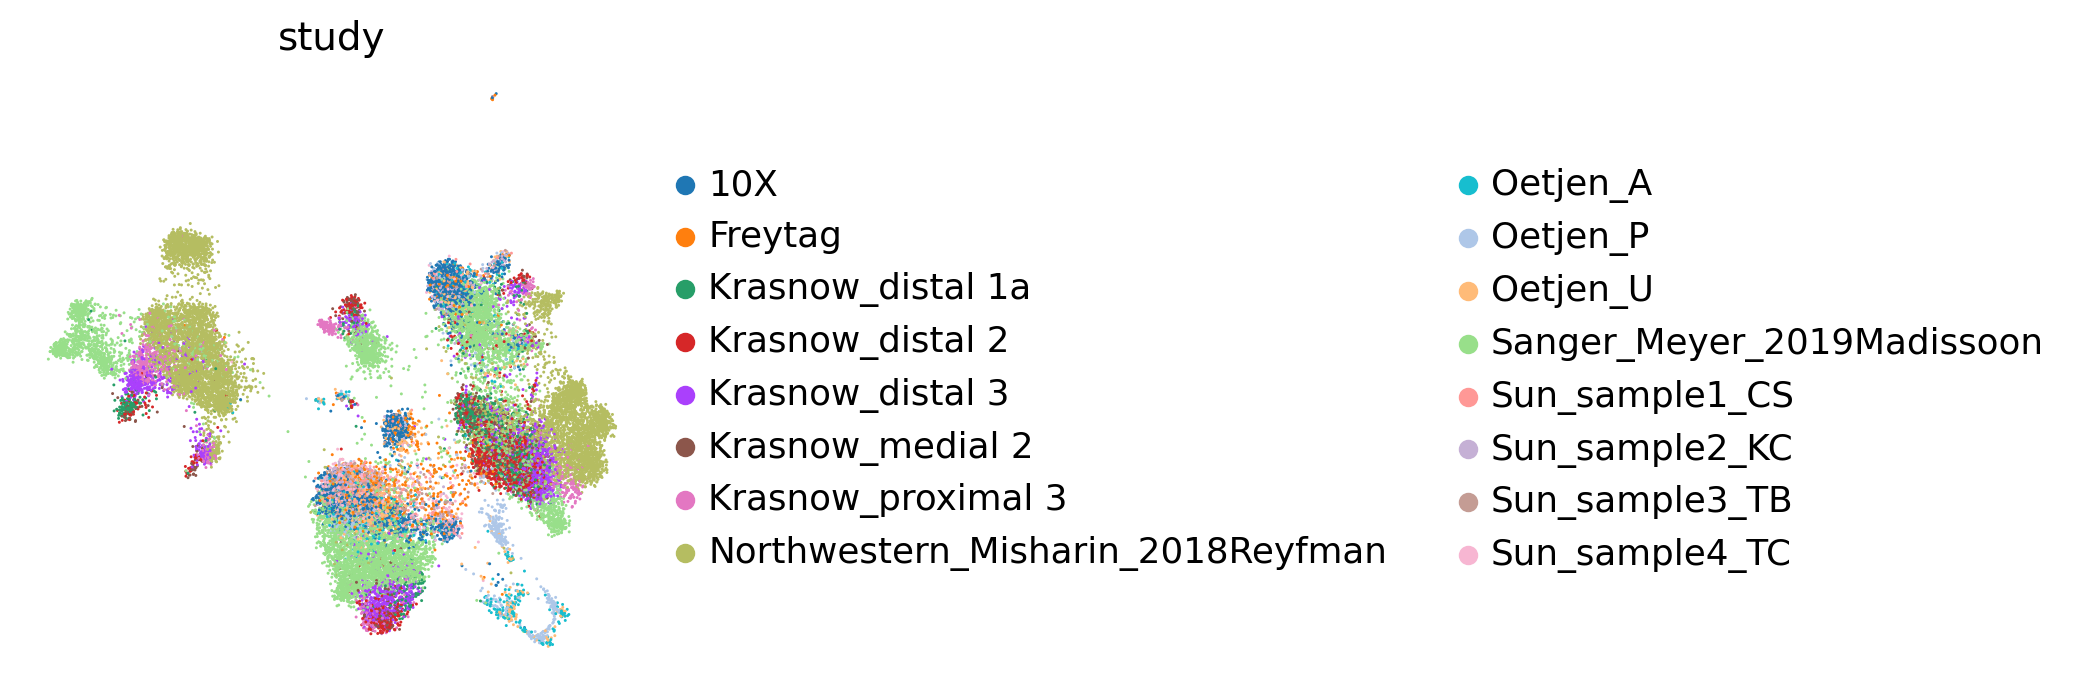

In [135]:
sc.pl.umap(ref_ss, color=['study'], frameon=False)

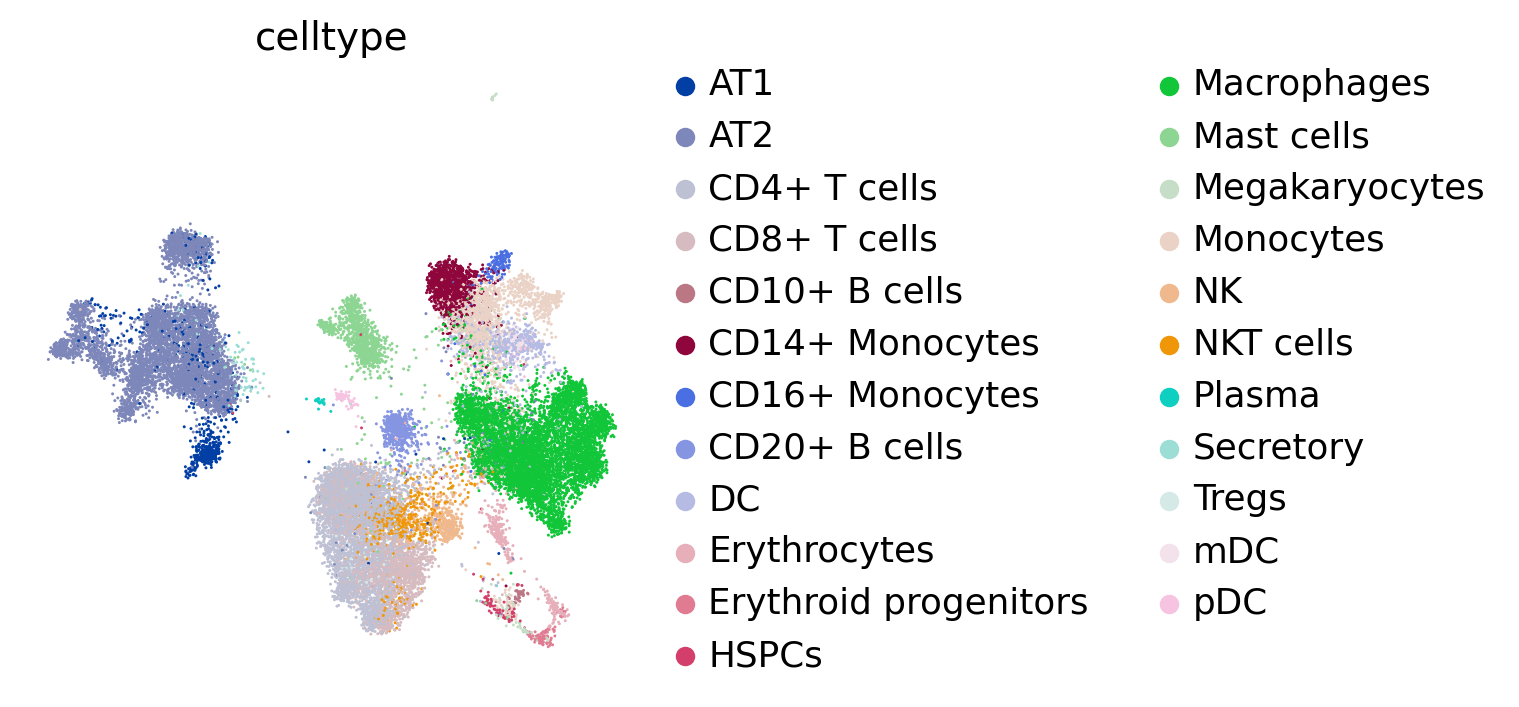

In [136]:
sc.pl.umap(ref_ss, color=['celltype'], frameon=False)

In [137]:
##### saving the model

In [28]:
name = "reference_covid_5k_new_3"

In [ ]:
intr_cvae.save(name)

In [30]:
query = query[:, adata.var_names].copy()

In [145]:
query.obs.sample_new.value_counts()

S2     16474
S1     11693
HC1     8429
HC2     8153
M1      3517
M2      3386
S6      2868
HC3     2555
S5      2041
S4      1705
S3      1292
M3       356
Name: sample_new, dtype: int64

#### Query training

In [26]:
query.obs.study = query.obs.sample_new.copy()

In [31]:
q_intr_cvae = sca.models.TRVAE.load_query_data(query, name)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 5000 545 28
	Hidden Layer 1 in/out: 545 545
	Mean/Var Layer in/out: 545 545
Encoder Architecture:
	Input Layer in, out and cond: 5000 128 28
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  545 5000 28


In [784]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
ALPHA = None
EPOCHS = 400

In [785]:
q_intr_cvae.train(n_epochs=300, alpha_epoch_anneal=70, weight_decay=0.0,
                  alpha_kl=0.07, seed=2020,    alpha=ALPHA, 
 use_early_stopping=True, 
                  early_stopping_kwargs=early_stopping_kwargs)


 |██████████----------| 52.3%  - epoch_loss: 2224.12 - epoch_recon_loss: 2204.71 - epoch_kl_loss:  277.25 - val_loss: 2017.00 - val_recon_loss: 1998.01 - val_kl_loss:  271.28
ADJUSTED LR
 |████████████--------| 62.3%  - epoch_loss: 2227.06 - epoch_recon_loss: 2207.65 - epoch_kl_loss:  277.23 - val_loss: 2016.13 - val_recon_loss: 1997.15 - val_kl_loss:  271.18
ADJUSTED LR
 |█████████████-------| 66.7%  - epoch_loss: 2221.90 - epoch_recon_loss: 2202.51 - epoch_kl_loss:  277.02 - val_loss: 2017.13 - val_recon_loss: 1998.15 - val_kl_loss:  271.22
ADJUSTED LR
 |██████████████------| 71.0%  - epoch_loss: 2224.83 - epoch_recon_loss: 2205.42 - epoch_kl_loss:  277.31 - val_loss: 2016.40 - val_recon_loss: 1997.41 - val_kl_loss:  271.20
ADJUSTED LR
 |██████████████------| 74.7%  - epoch_loss: 2228.48 - epoch_recon_loss: 2209.07 - epoch_kl_loss:  277.23 - val_loss: 2016.98 - val_recon_loss: 1997.99 - val_kl_loss:  271.21
Stopping early: no improvement of more than 0 nats in 50 epochs
If the early 

In [803]:
# q_intr_cvae.save("reference_covid_5k_new_3+query_2_new")

In [ ]:
intr_cvae.save(name)

In [ ]:
q_intr_cvae = sca.models.trVAE.load()

In [32]:
# q_intr_cvae.load("reference_covid_5k_new_3+query_2_new",adata)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 5000 545 28
	Hidden Layer 1 in/out: 545 545
	Mean/Var Layer in/out: 545 545
Encoder Architecture:
	Input Layer in, out and cond: 5000 128 28
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  545 5000 28


In [150]:
adata_all = sc.AnnData.concatenate(query, adata, batch_key='batch_join')

In [53]:
q_intr_cvae = sca.models.TRVAE.load("reference_covid_5k_new_3+query_2_new", adata_all)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 5000 545 28
	Hidden Layer 1 in/out: 545 545
	Mean/Var Layer in/out: 545 545
Encoder Architecture:
	Input Layer in, out and cond: 5000 128 28
	Mean/Var Layer in/out: 128 1
Decoder Architecture:
	Masked linear layer in, out and cond:  545 5000 28


In [50]:
# q_intr_cvae = q_intr_cvae.save("reference_covid_5k_new_3+query_2_new")

NameError: name 's' is not defined

#### Latent space for query data 

In [54]:
MEAN = False

In [122]:
query.obsm['X_cvae'] = q_intr_cvae.get_latent(query.X.A, query.obs.study, mean=MEAN)[:, ~inactive_idx]

In [56]:
q_ss= sc.pp.subsample(query, copy=True, fraction=0.2)

In [57]:
sc.pp.neighbors(q_ss, use_rep='X_cvae')

In [58]:
sc.tl.umap(q_ss)

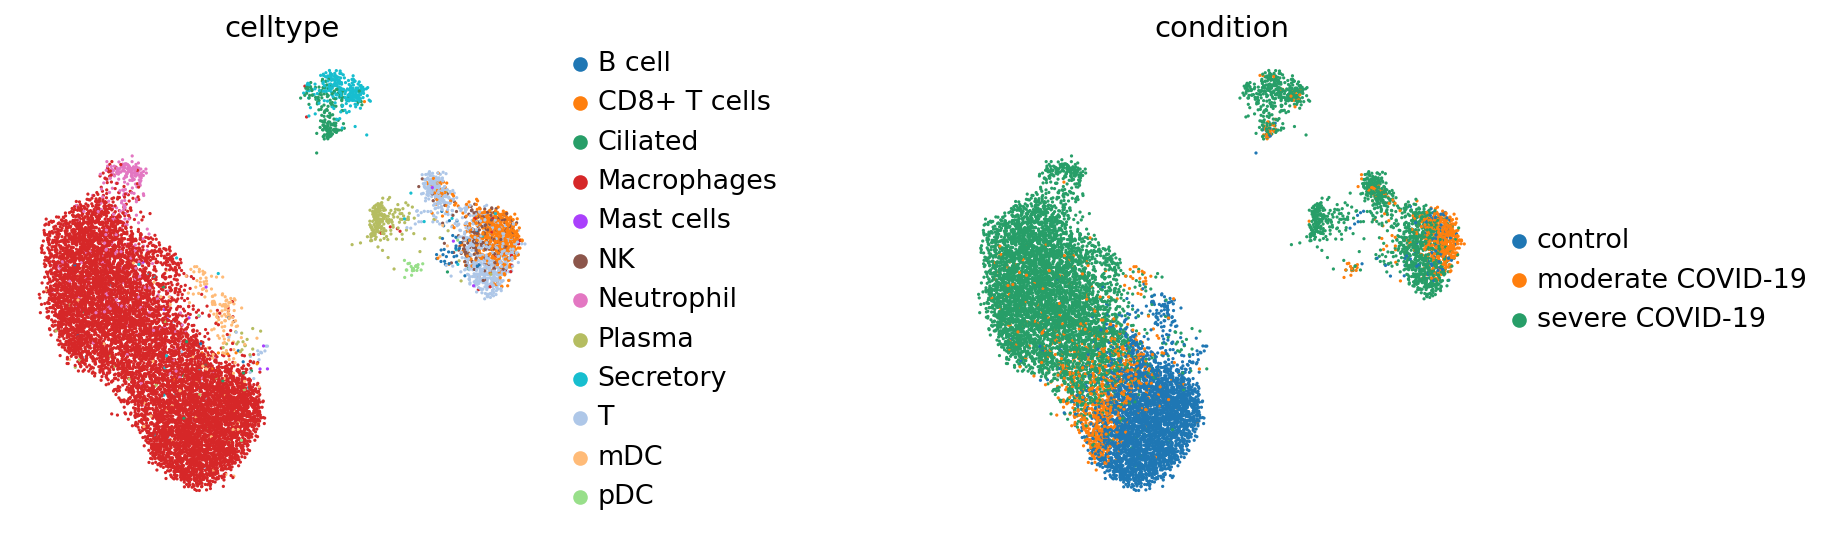

In [59]:
sc.pl.umap(q_ss, color=['celltype', 'condition'], frameon=False, wspace=0.6)

#### Joint embedding of query and the reference 

In [60]:
# adata_all = sc.AnnData.concatenate(query, adata, batch_key='batch_join')

In [123]:
adata_all.obsm['X_cvae'] = q_intr_cvae.get_latent(adata_all.X.A, 
                                                  adata_all.obs['study'].tolist(),
                                                  mean=MEAN)[:, ~inactive_idx]

In [62]:
adata_all_ss = sc.pp.subsample(adata_all, fraction=0.2, copy=True)

In [63]:
sc.pp.neighbors(adata_all, use_rep='X_cvae')
sc.tl.umap(adata_all)

... storing 'age_range' as categorical
... storing 'anatomical_region' as categorical
... storing 'batch' as categorical
... storing 'dataset' as categorical
... storing 'donor' as categorical
... storing 'ethnicity' as categorical
... storing 'last_author/PI' as categorical
... storing 'lung_vs_nasal' as categorical
... storing 'original_celltype_ann' as categorical
... storing 'pack_years' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'smoking' as categorical
... storing 'ann_level_1' as categorical
... storing 'ann_level_2' as categorical
... storing 'ann_level_3' as categorical
... storing 'ann_level_4' as categorical
... storing 'ann_level_5' as categorical
... storing 'ann_new' as categorical
... storing 'subject_type' as categorical
... storing 'study' as categorical
... storing 'study2' as categorical
... storing 'celltype' as categorical
... storing 'condition' as categorical
... storing 'ID' as categorical
... storing 'sample_

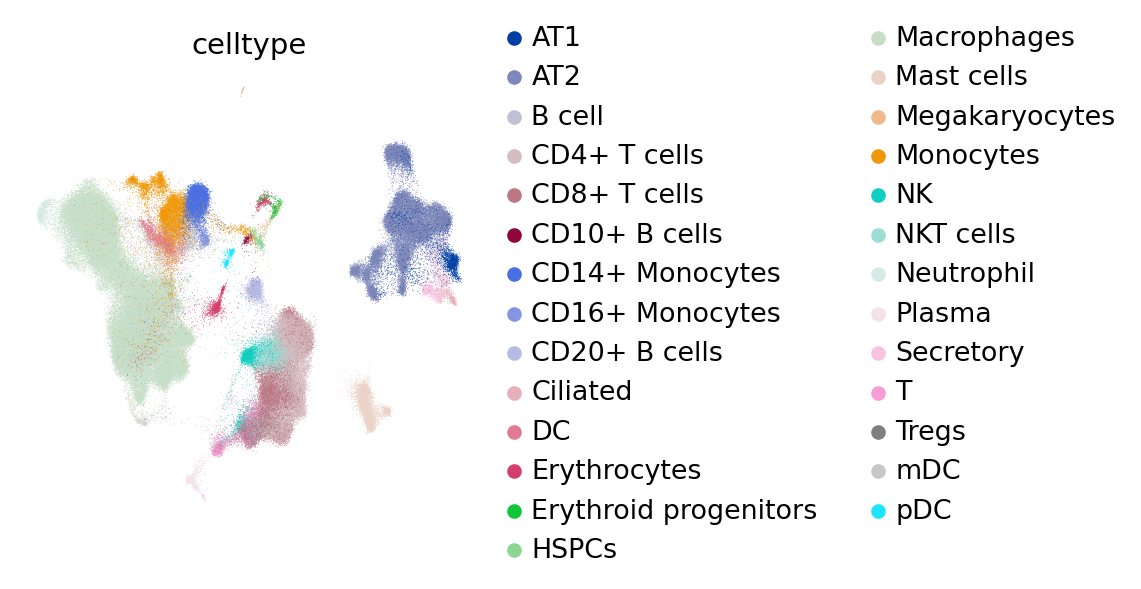

In [64]:
sc.pl.umap(adata_all, color=['celltype'], frameon=False, wspace=0.6, palette=sc.pl.palettes.default_28, save="ct_re_q.pdf")

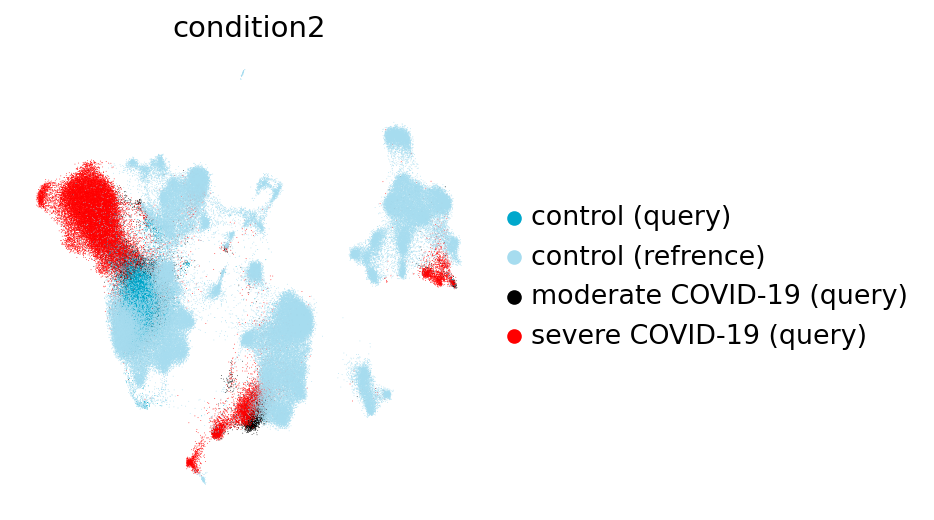

In [72]:
sc.pl.umap(adata_all, color=['condition2'], palette=["#00a8cc","#a6dcef","black","red"],
           frameon=False, wspace=0.6,save="condition_ref_query")

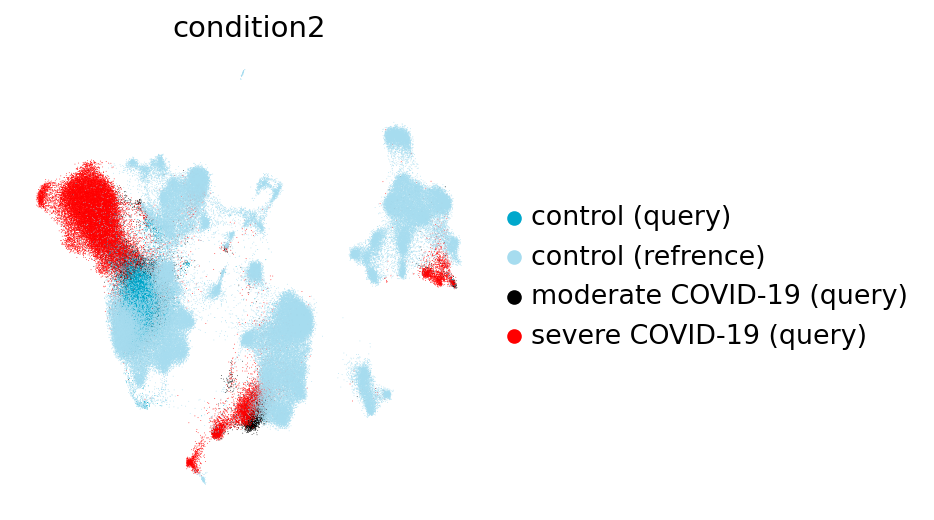

In [66]:
sc.pl.umap(adata_all, color=['condition2'], palette=["#00a8cc","#a6dcef","black","red"],
           frameon=False, wspace=0.6,save="condition_ref_query")

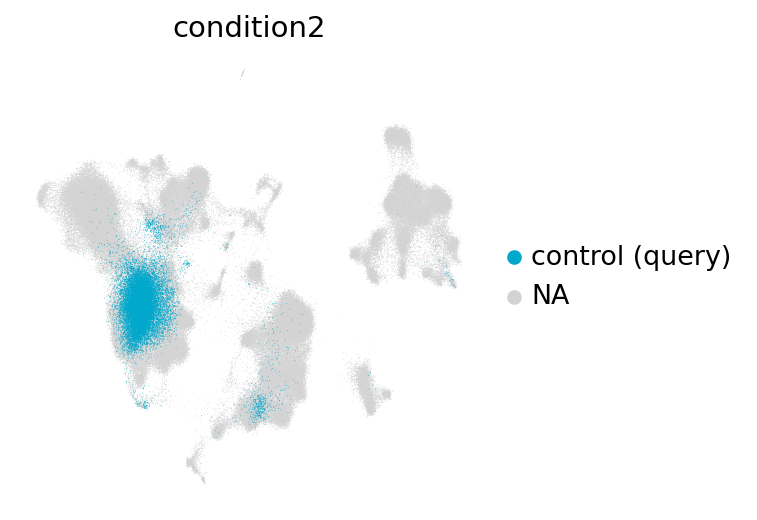

In [67]:
sc.pl.umap(adata_all, color=['condition2'], groups=["control (query)"], frameon=False, wspace=0.6,save="control_query")

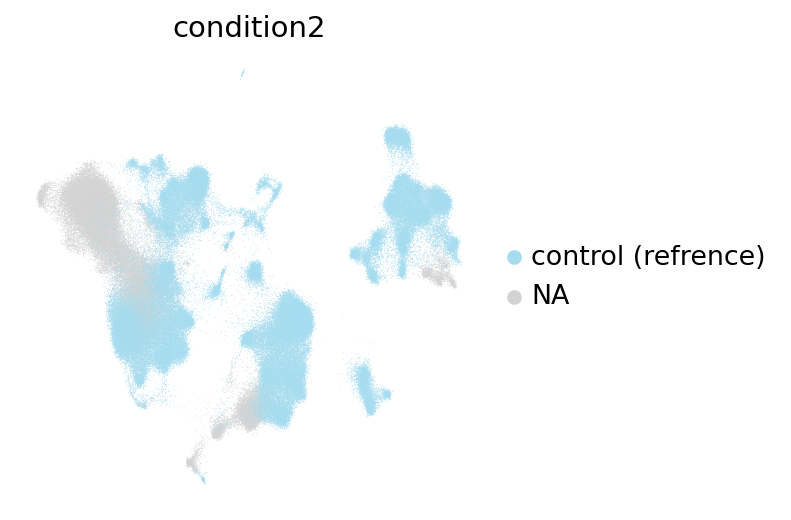

In [68]:
sc.pl.umap(adata_all, color=['condition2'], groups=["control (refrence)"],
           frameon=False, wspace=0.6, save="control_ref")

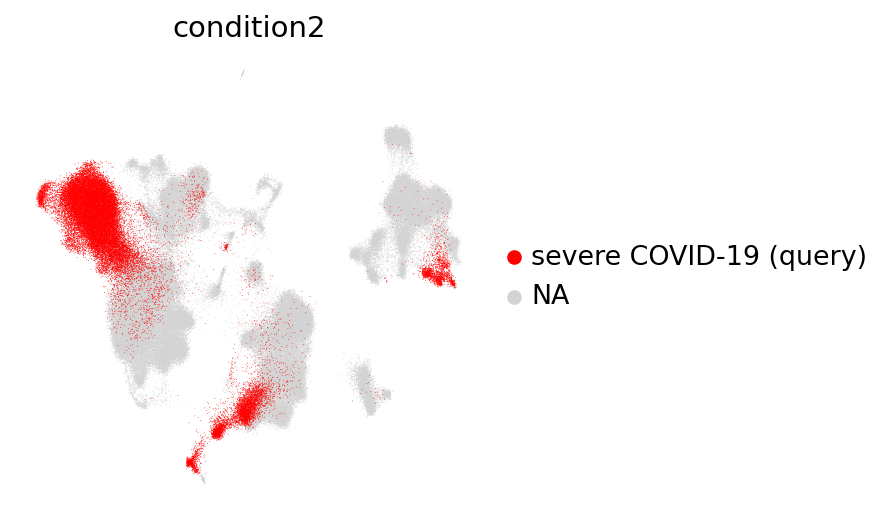

In [69]:
sc.pl.umap(adata_all, color=['condition2'], groups=["severe COVID-19 (query)"],
           frameon=False, wspace=0.6, save="severe")

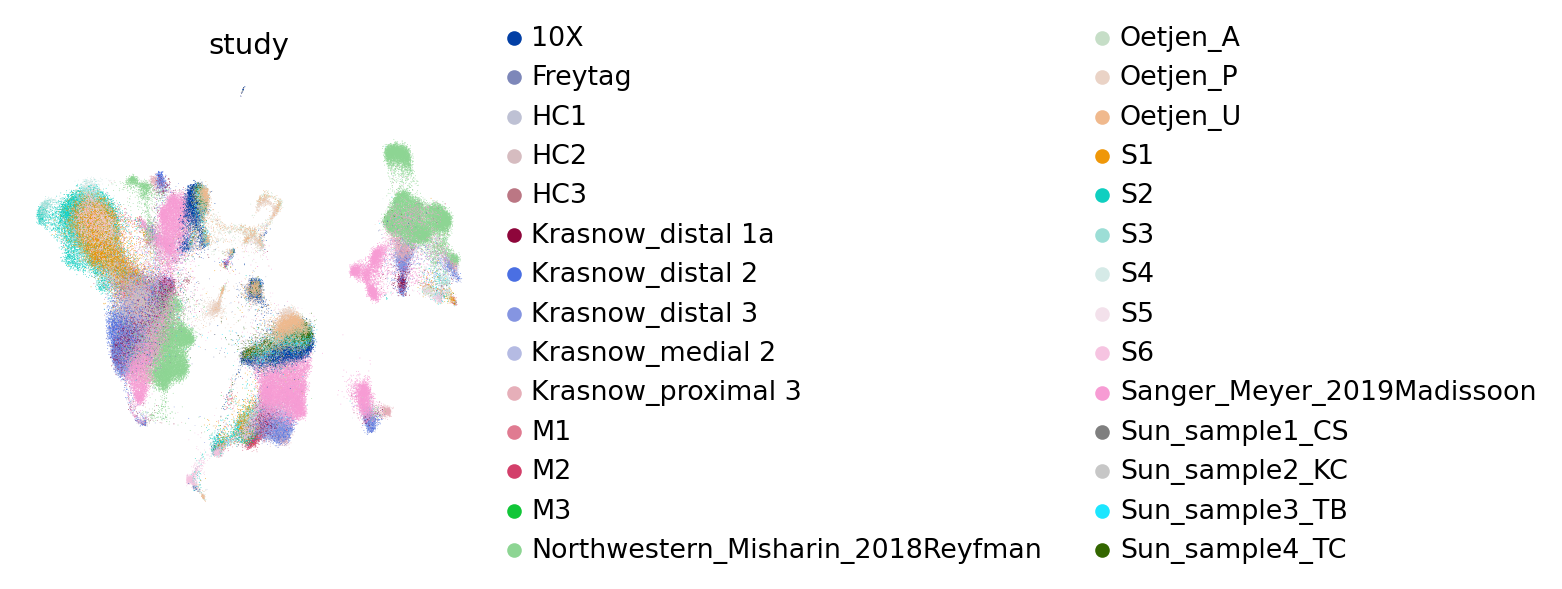

In [70]:
sc.pl.umap(adata_all, color=['study'],
           frameon=False, wspace=0.6, save="study")

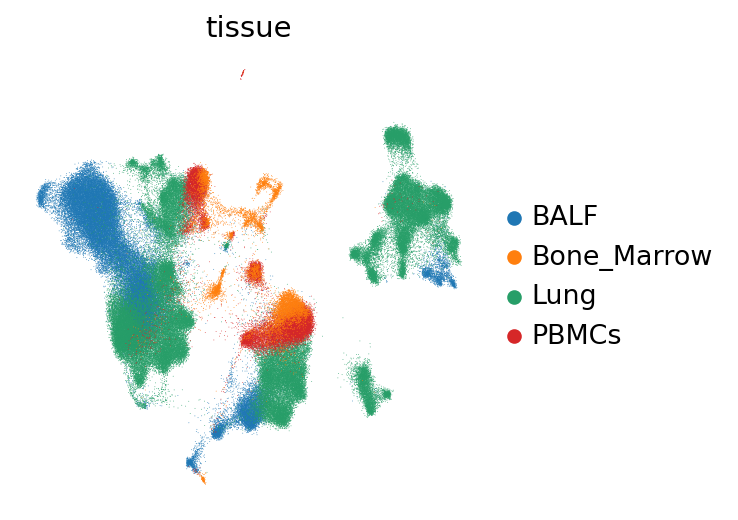

In [71]:
sc.pl.umap(adata_all, color=['tissue'],
           frameon=False, wspace=0.6, save="tissue")

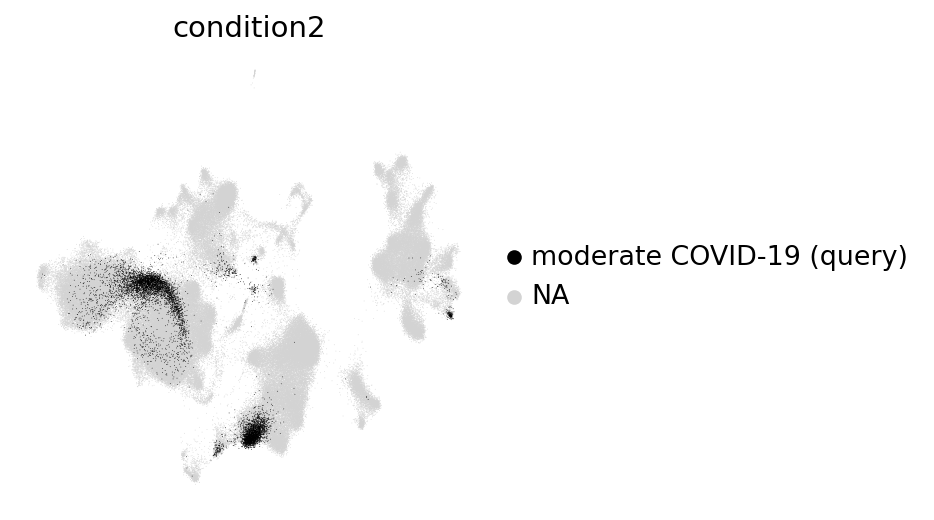

In [818]:
sc.pl.umap(adata_all, color=['condition2'], groups=["moderate COVID-19 (query)"],
           frameon=False, wspace=0.6, save="moderate")

### Diffrerential enrichment analysis

In [124]:
adata_all.obs.condition2 = adata_all.obs.condition2.astype('category')
adata_all.obs.condition = adata_all.obs.condition.astype('category')

In [125]:
adata_all.uns["terms"] = np.array(adata.uns["terms"])
# adata_all.uns["active_terms"] = np.array(adata.uns["active_terms"])
adata_all.uns['active_terms'] = np.array(adata.uns['terms'])[q_intr_cvae.model.decoder.nonzero_terms()]

### setting directions

In [126]:
directions = q_intr_cvae._latent_directions(method="sum")

In [127]:
adata_all.obsm['X_cvae']= adata_all.obsm['X_cvae'][:,q_intr_cvae.model.decoder.nonzero_terms()]

In [128]:
adata_all.obsm['X_cvae'] *= directions[q_intr_cvae.model.decoder.nonzero_terms()]

latent enrich for conditions for cell types 

In [129]:
adata_all.X = adata_all.X.A

In [130]:
scores_ct = q_intr_cvae.latent_enrich('celltype', comparison="rest", adata=adata_all, directions=directions, n_perm=10000)

In [131]:
scores_cond = q_intr_cvae.latent_enrich('condition', comparison="control", adata=adata_all, directions=directions,n_perm=10000)

helper function to filter pathways according to bayse factor

In [132]:
def filter_set_scores(scores, adata, filter_v=2.31):
    score_dict = {}
    for k in scores:
        score_dict[k] = {}
        mask = np.abs(scores[k]['bf']) > filter_v
        s = sum(mask)
        if s > 0:
            sort = np.argsort(np.abs(scores[k]['bf'])[mask])[::-1]
            enriched_terms = adata.uns['terms'][mask][sort]
            score_dict[k]["terms"] = enriched_terms
            score_dict[k]["scores"] = scores[k]['bf'][mask][sort]
#             print(enriched_terms)
#             print(scores[k]['bf'][mask][sort])
            for term in enriched_terms:
                adata.obs[term] = adata.obsm['X_cvae'][:, adata.uns['active_terms'] == term]
    return score_dict

In [133]:
path_ways_ct = filter_set_scores(scores_ct, adata_all, filter_v=2)

In [134]:
path_ways_cond = filter_set_scores(scores_cond, adata_all, filter_v=2)

In [135]:
path_ways_cond

{'moderate COVID-19': {'terms': array(['REACTOME_INTERFERON_SIGNALING'], dtype='<U132'),
  'scores': array([2.66])},
 'severe COVID-19': {'terms': array(['REACTOME_INTERFERON_SIGNALING',
         'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'], dtype='<U132'),
  'scores': array([3.19, 2.1 ])}}

ploting diff pathwayys per condition

severe COVID-19


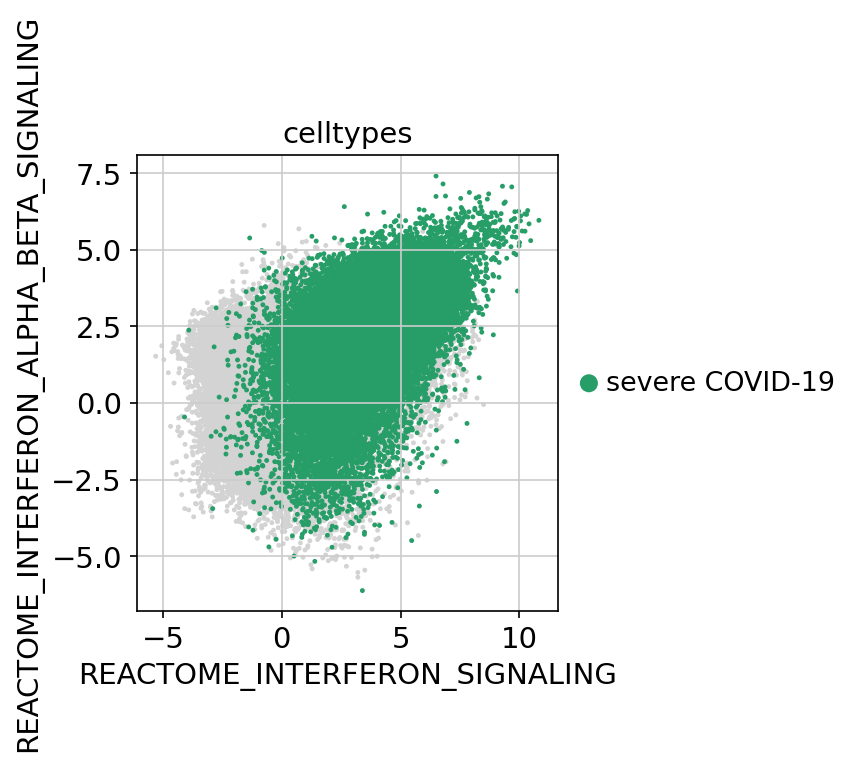

In [833]:
for ct in path_ways_cond.keys():
    if(len(path_ways_cond[ct]))<1:
        continue
    if len(path_ways_cond[ct]["terms"]) >=2:
        print(ct)
        sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][0], y=path_ways_cond[ct]["terms"][1], 
              color='condition', size=22, title='celltypes', groups=f"{ct}")
        if len(path_ways_cond[ct]["terms"]) >2:
            sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][0], y=path_ways_cond[ct]["terms"][2], 
          color='condition', size=22, title='condition', groups=f"{ct}")
            sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][1], y=path_ways_cond[ct]["terms"][2], 
          color='condition', size=22, title='condition', groups=f"{ct}")
    if len(path_ways_cond[ct]["terms"]) >3:
                    sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][1], y=path_ways_cond[ct]["terms"][3], 
          color='condition', size=22, title='condition', groups=f"{ct}")
                    sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][2], y=path_ways_cond[ct]["terms"][3], 
          color='condition', size=22, title='condition', groups=f"{ct}")
                    sc.pl.scatter(adata_all, x=path_ways_cond[ct]["terms"][0], y=path_ways_cond[ct]["terms"][3], 
          color='condition', size=22, title='condition', groups=f"{ct}")
                    
            


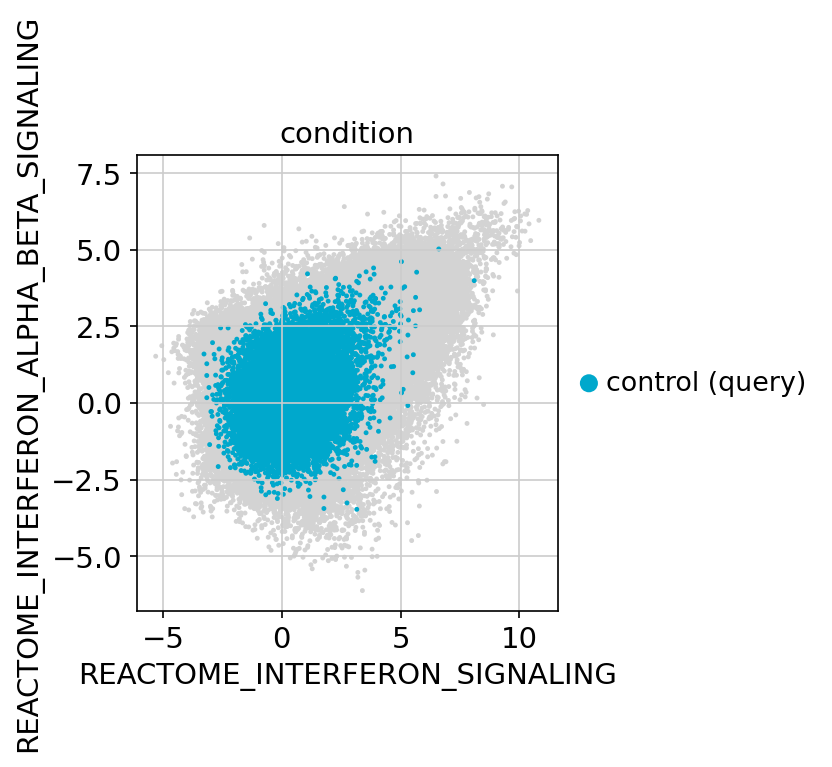

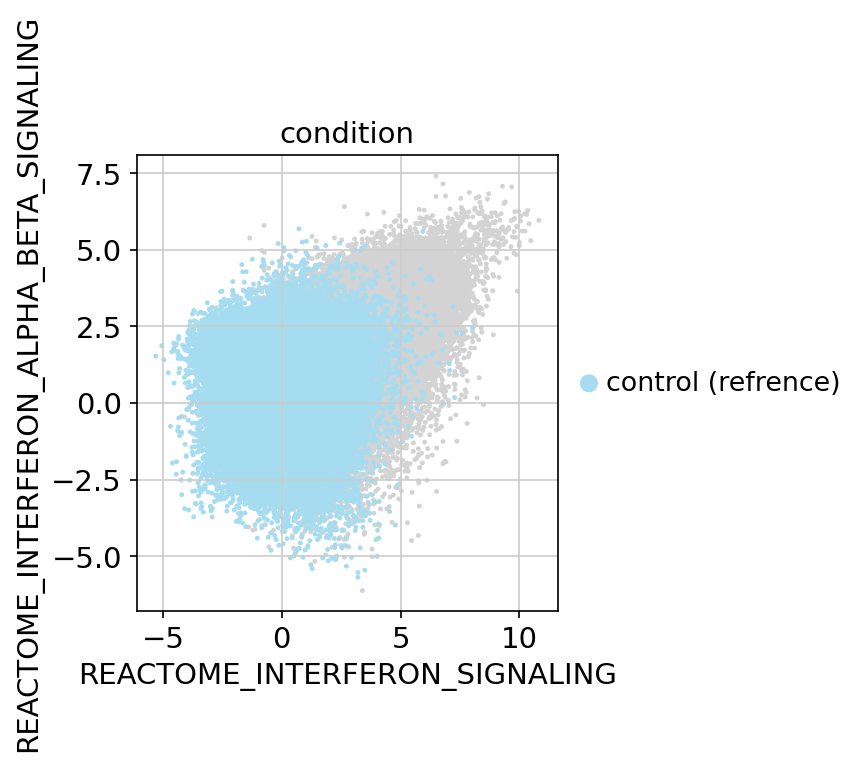

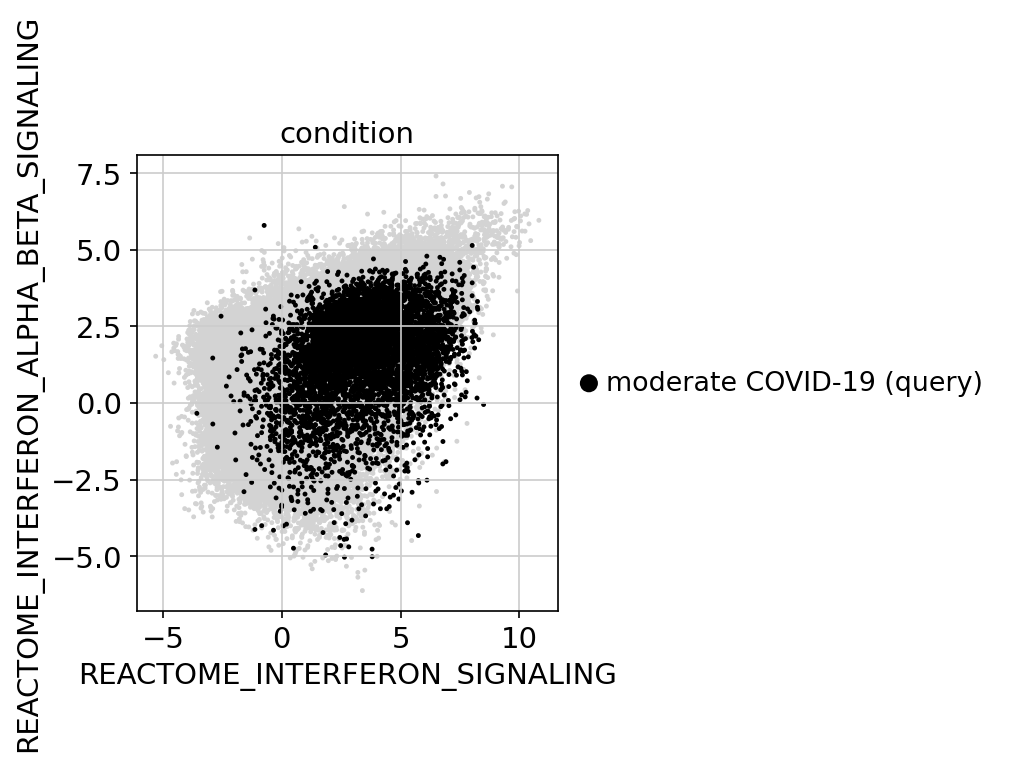

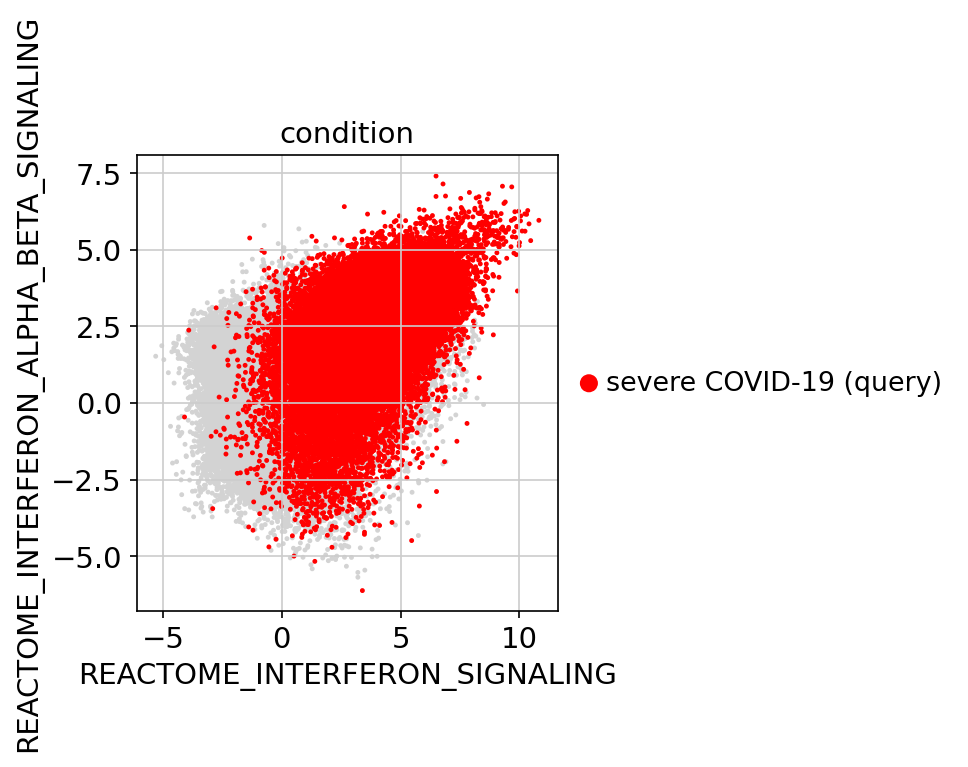

In [835]:
for i in  np.unique(adata_all.obs.condition2):
       sc.pl.scatter(adata_all, x="REACTOME_INTERFERON_SIGNALING", 
                  y="REACTOME_INTERFERON_ALPHA_BETA_SIGNALING", 
          color='condition2', size=22, title='condition'
                  , groups=f"{i}", palette=["#00a8cc","#a6dcef","black","red"], save=f"global_{i}")

#### celltype pathways for all cell types in the query data to determine the response

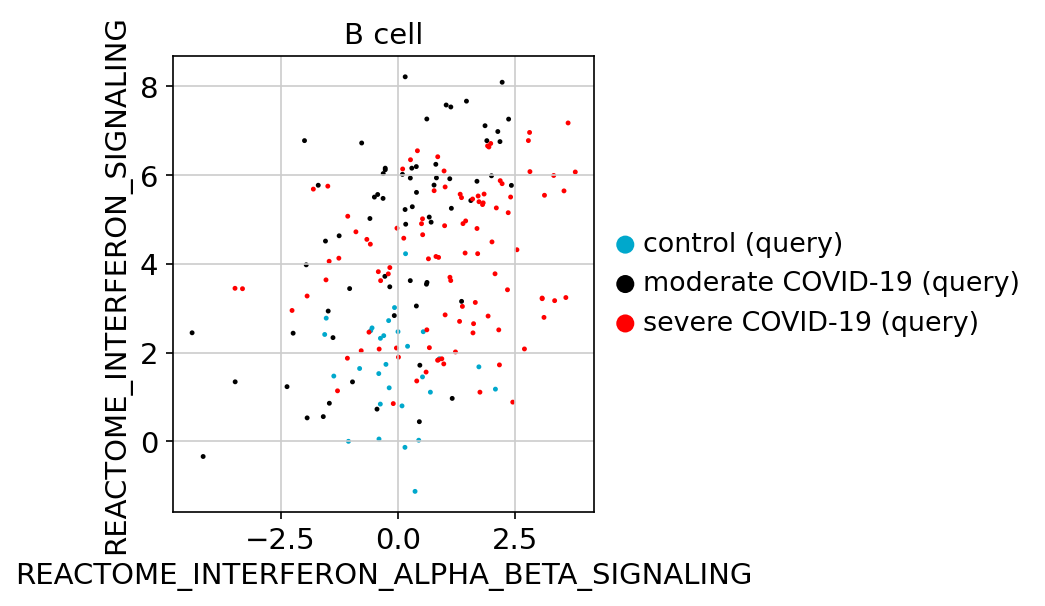

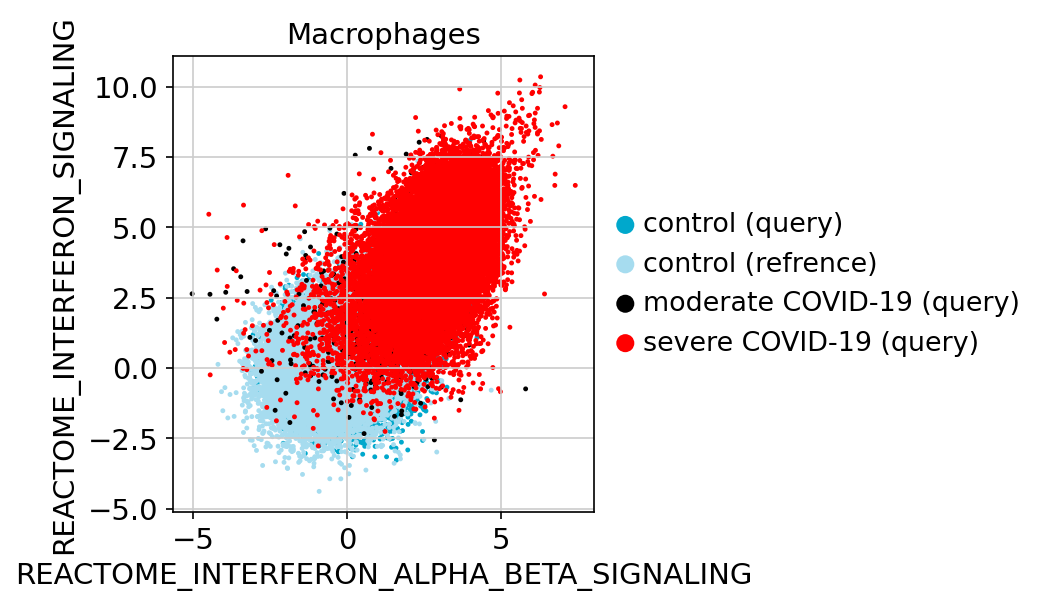

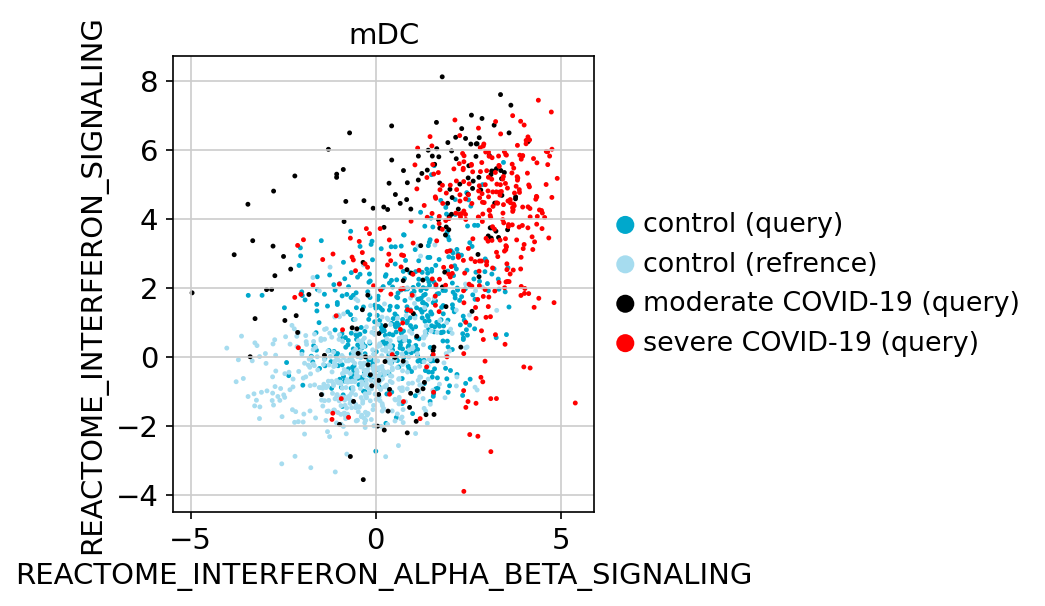

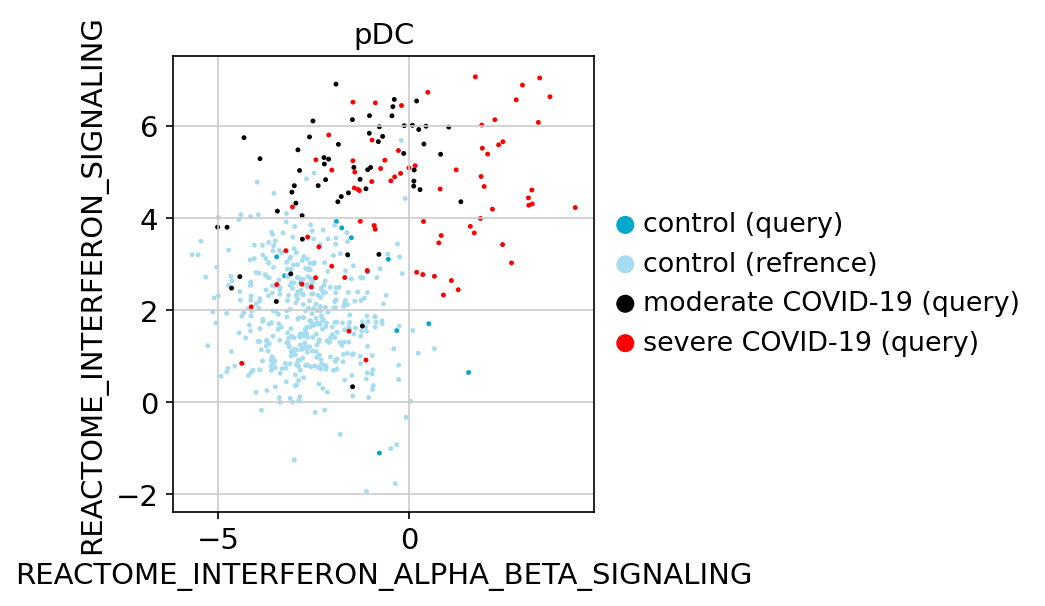

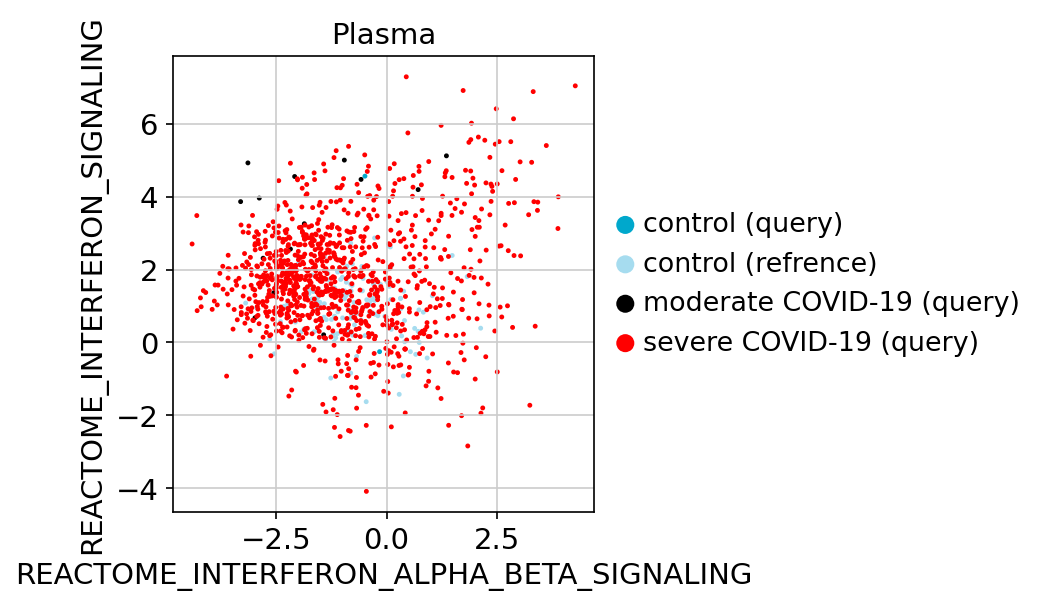

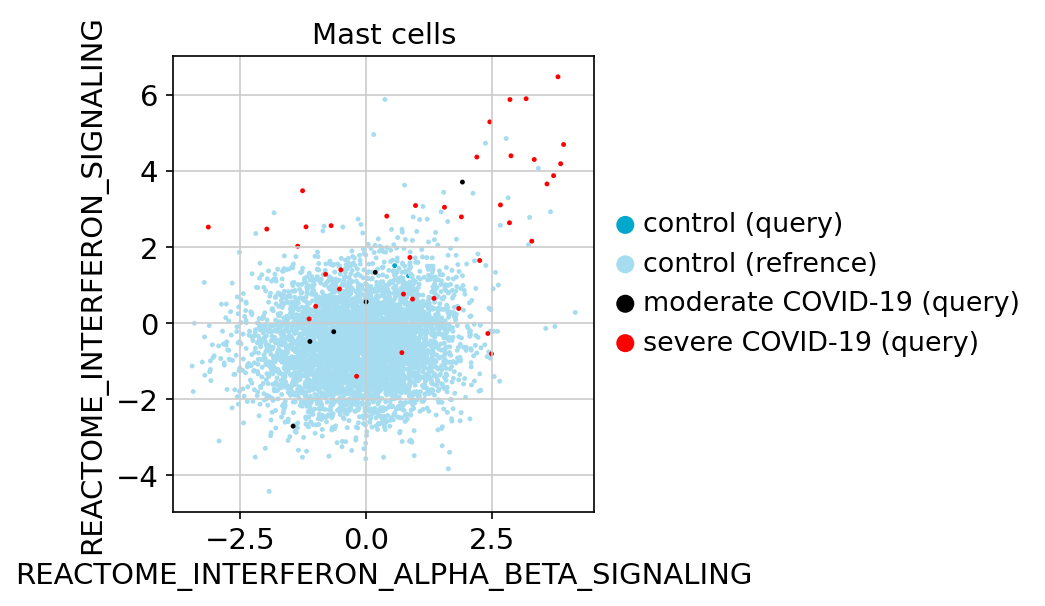

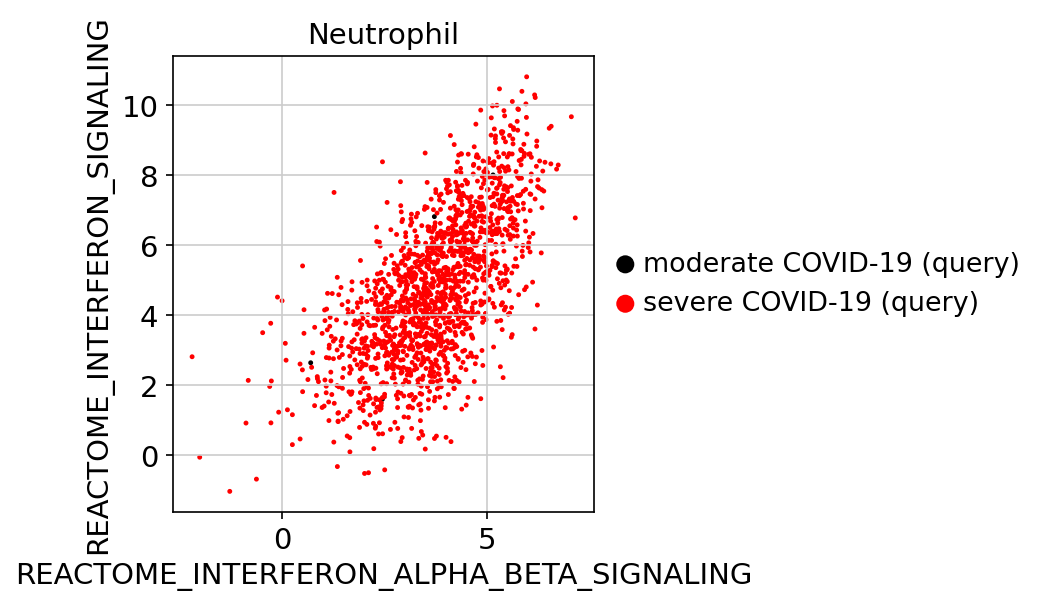

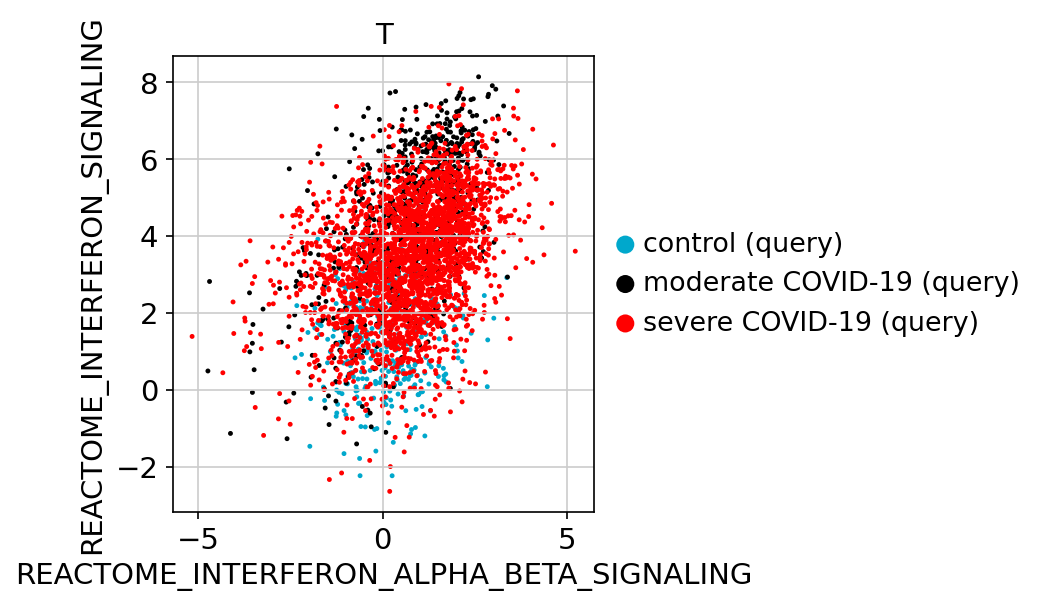

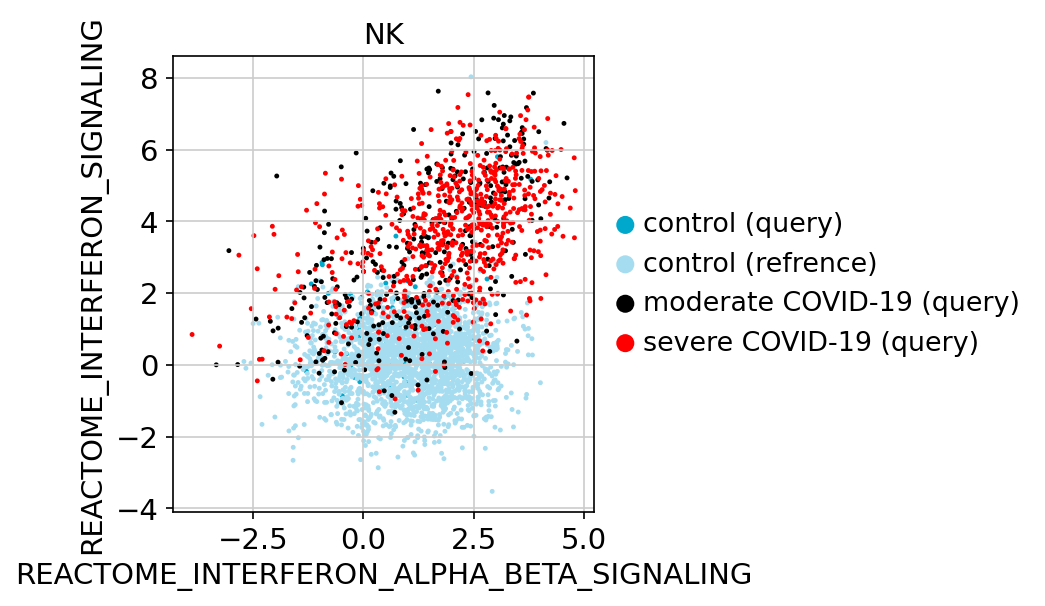

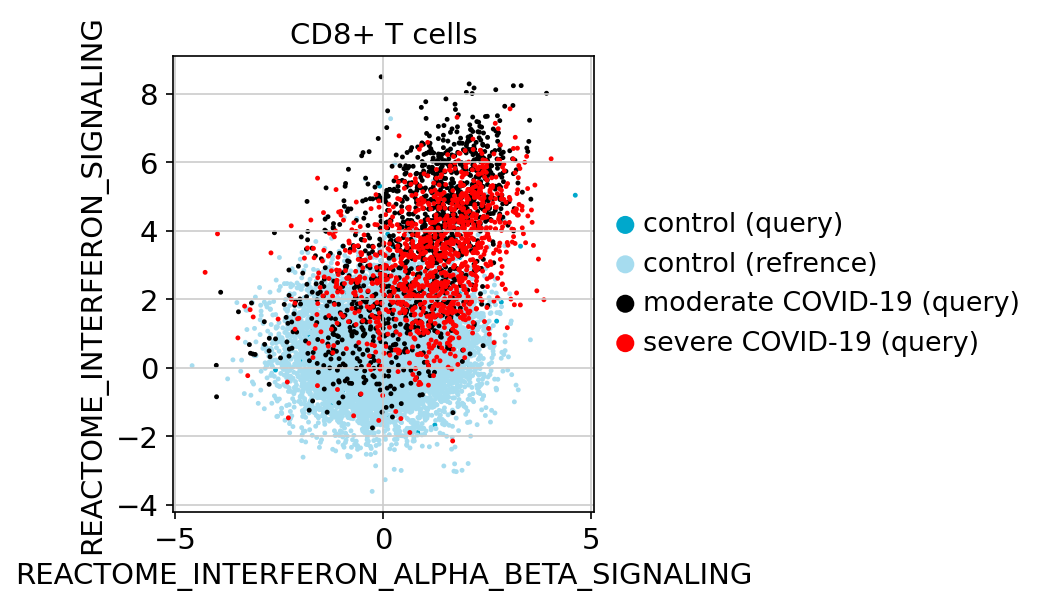

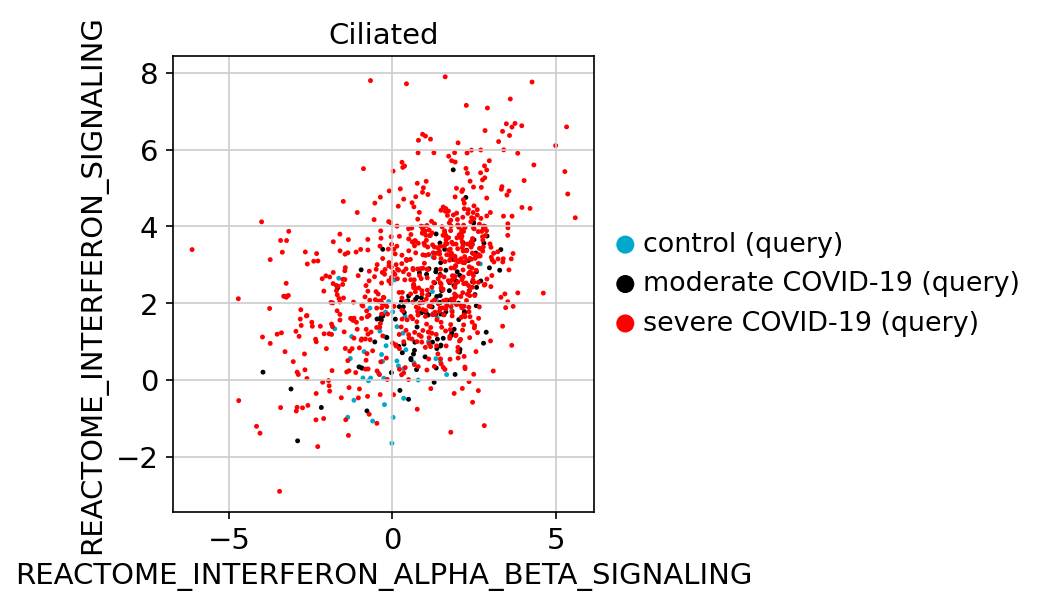

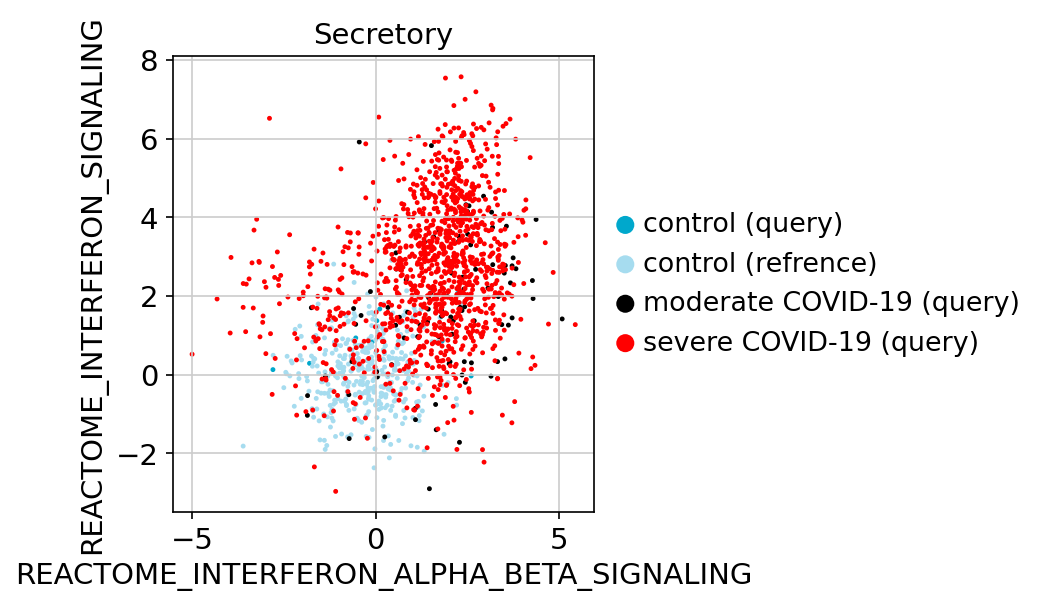

In [836]:
for i in query.obs.celltype.unique():
        adata_ct = adata_all[adata_all.obs.celltype == i]
        
#         sc.pl.scatter(adata_ct, x="REACTOME_INTERFERON_ALPHA_BETA_SIGNALING", 
#                   y="REACTOME_INTERFERON_SIGNALING", 
#           color='celltype', size=22, title='condition'
#                   , groups=f"{i}", legend_loc="on data",)
        sc.pl.scatter(adata_ct, x="REACTOME_INTERFERON_ALPHA_BETA_SIGNALING", 
                  y="REACTOME_INTERFERON_SIGNALING", 
          color='condition2', size=22, title=f'{i}')

#### celltype pathways for all cell types in  query to determine the cell types

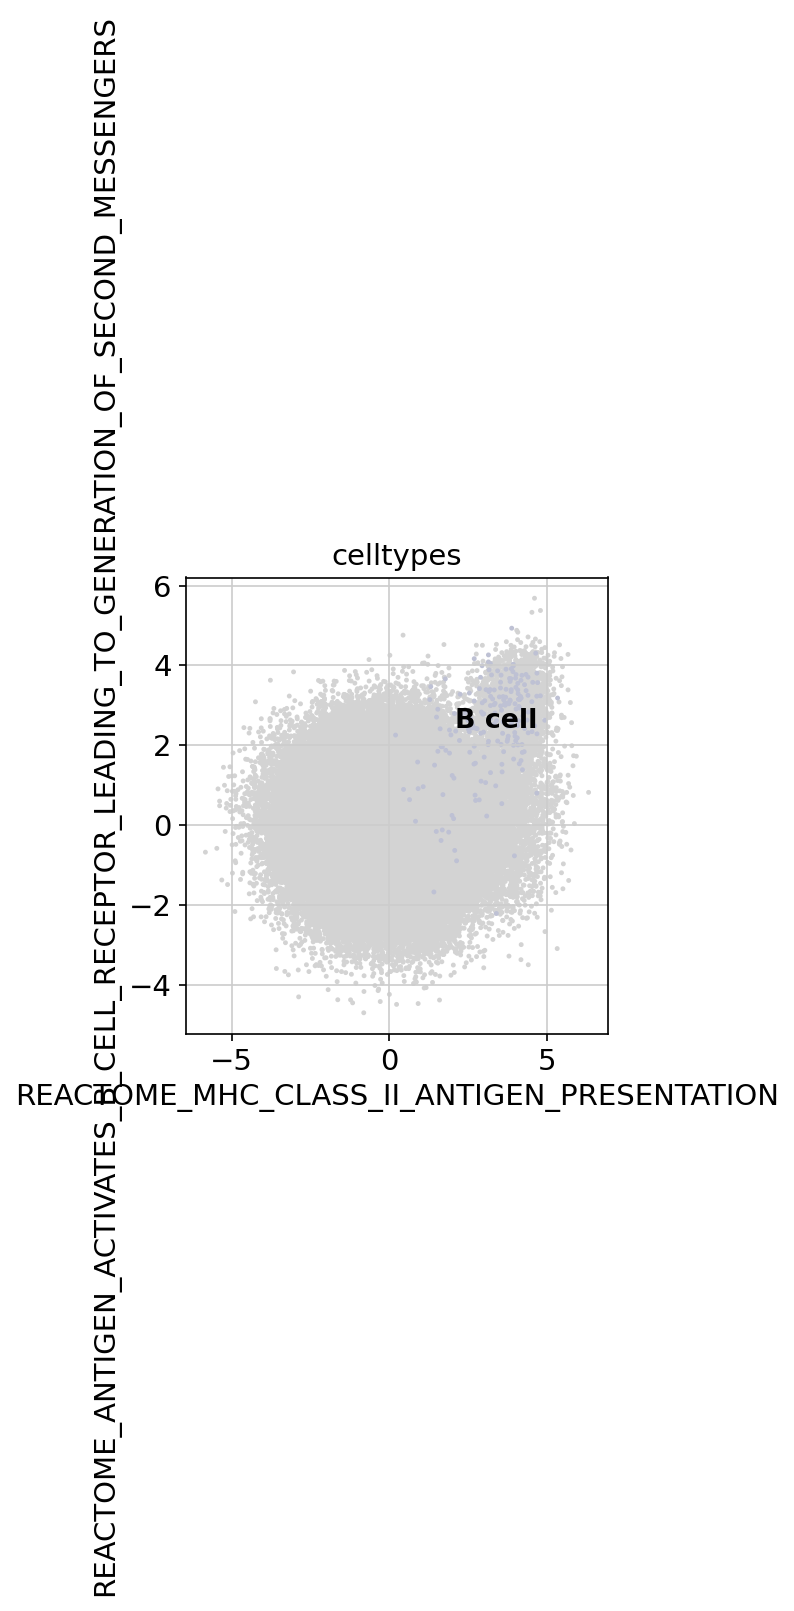

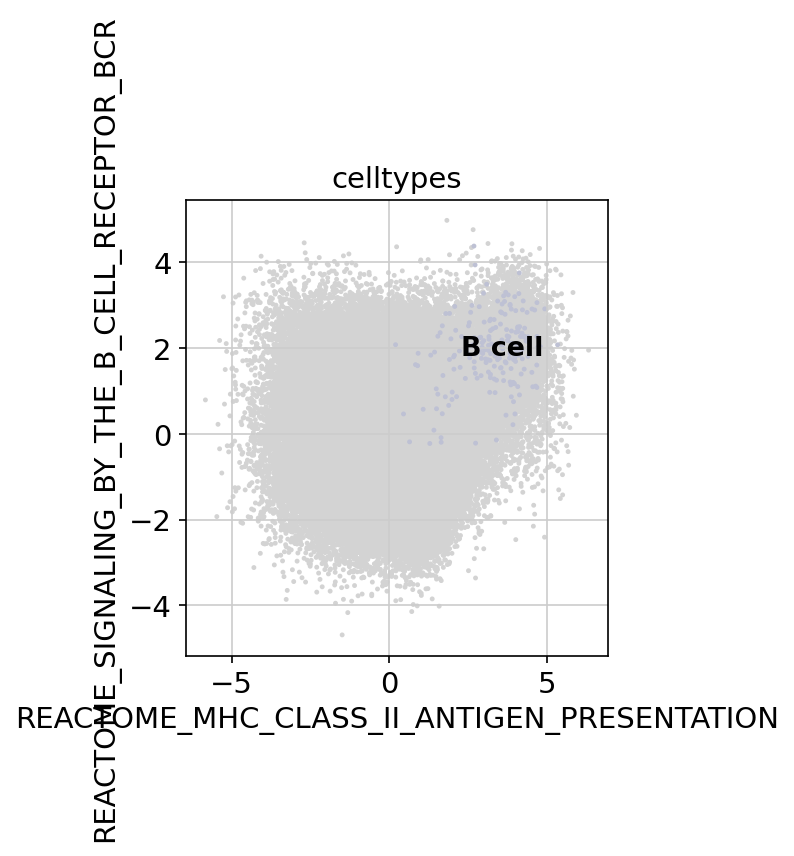

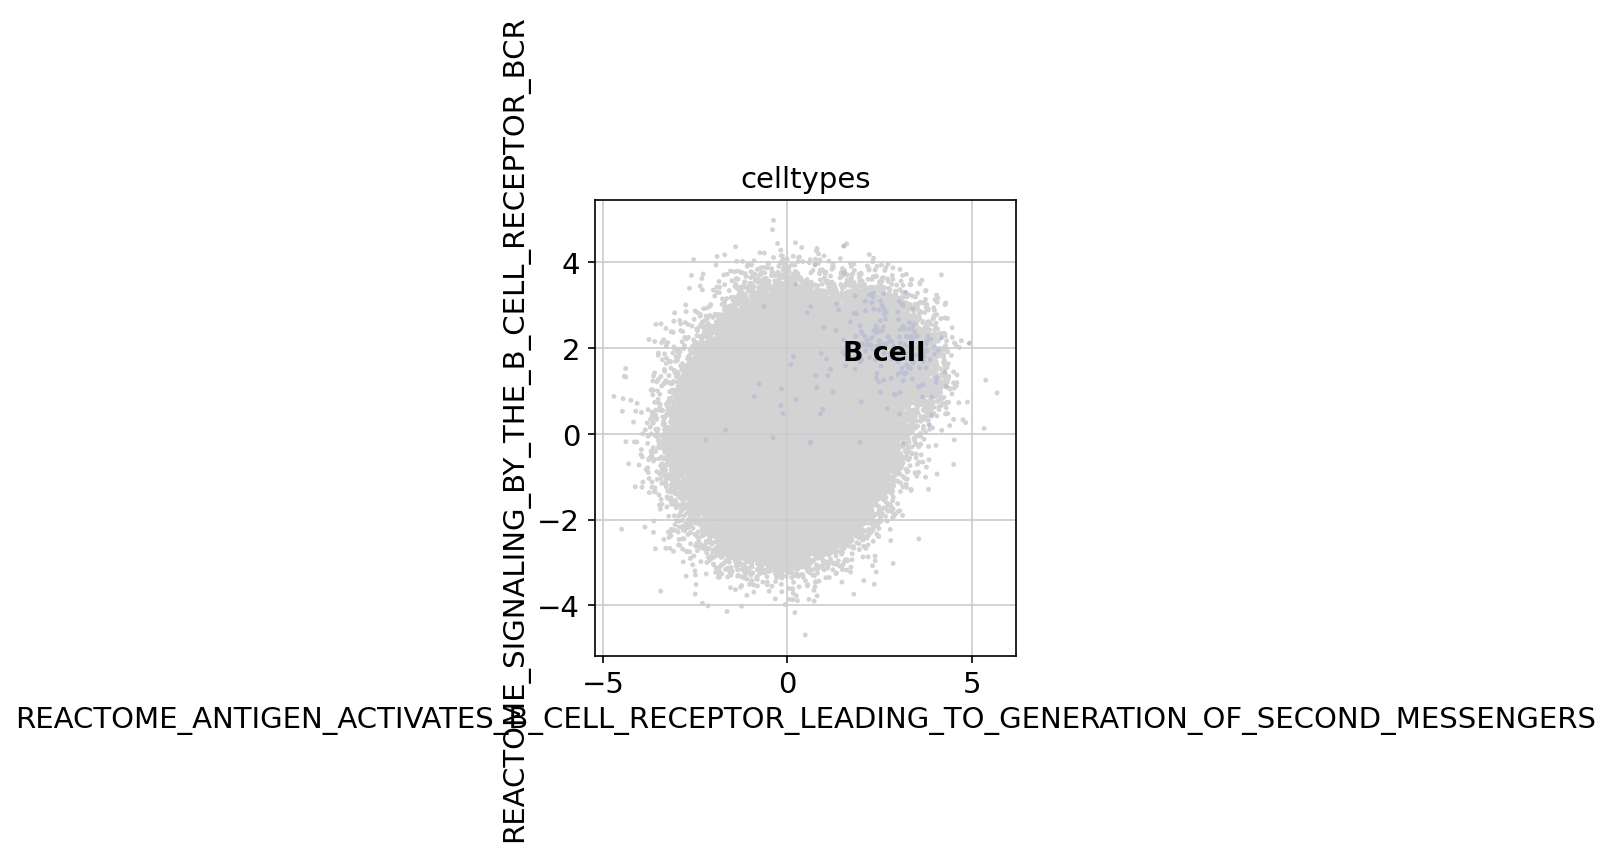

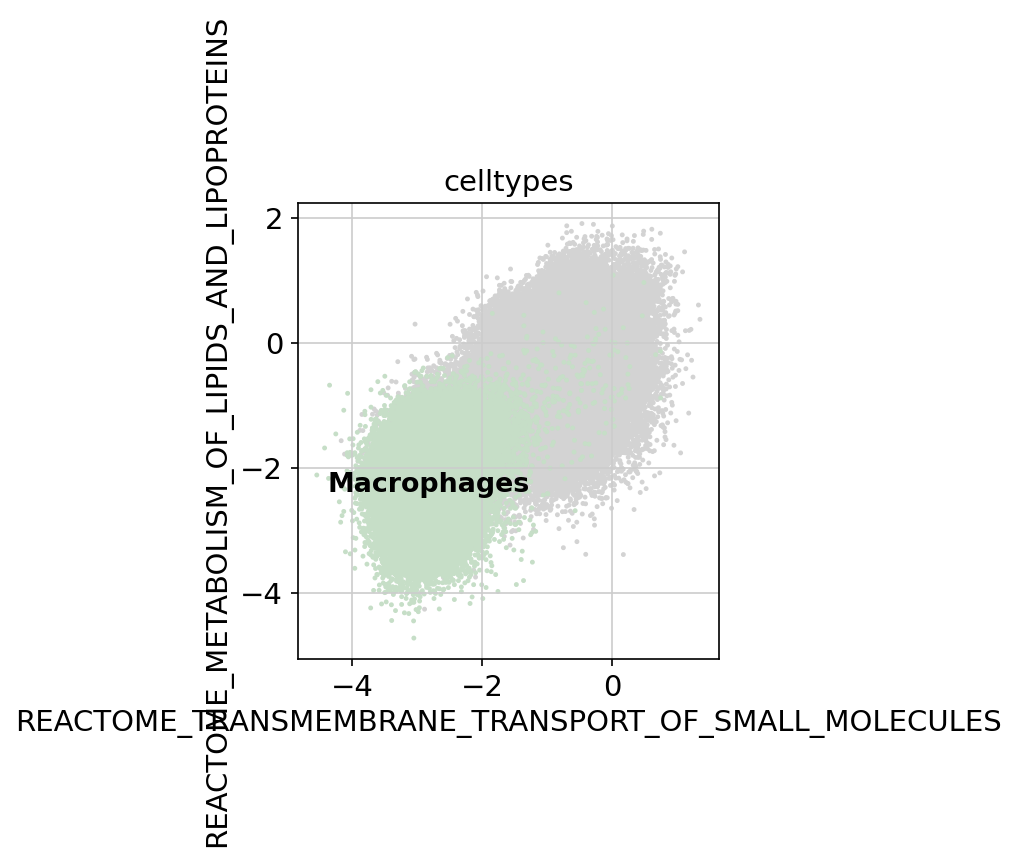

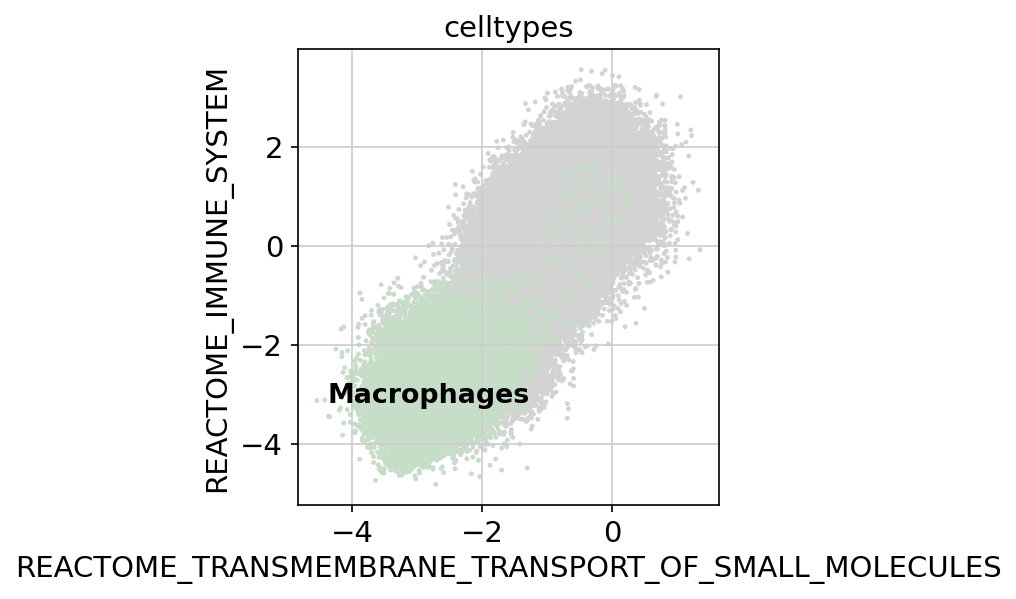

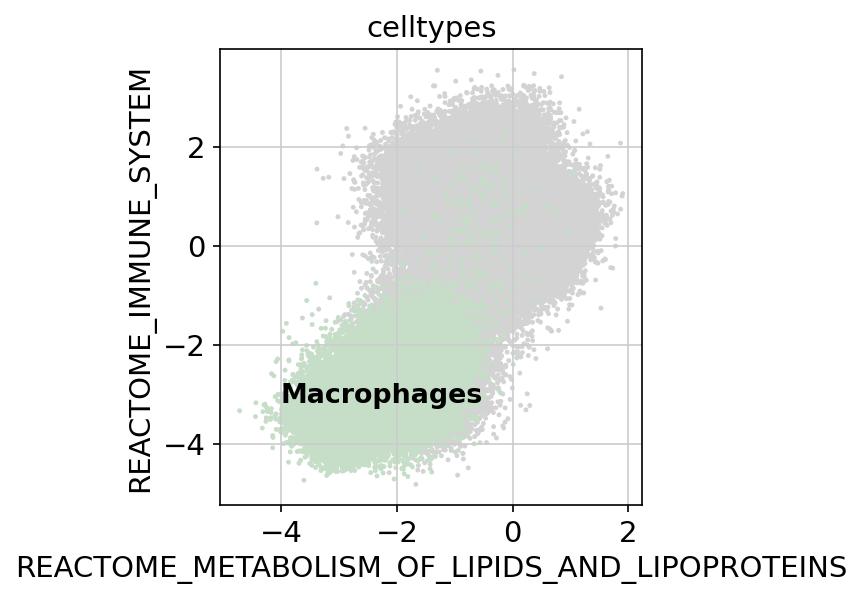

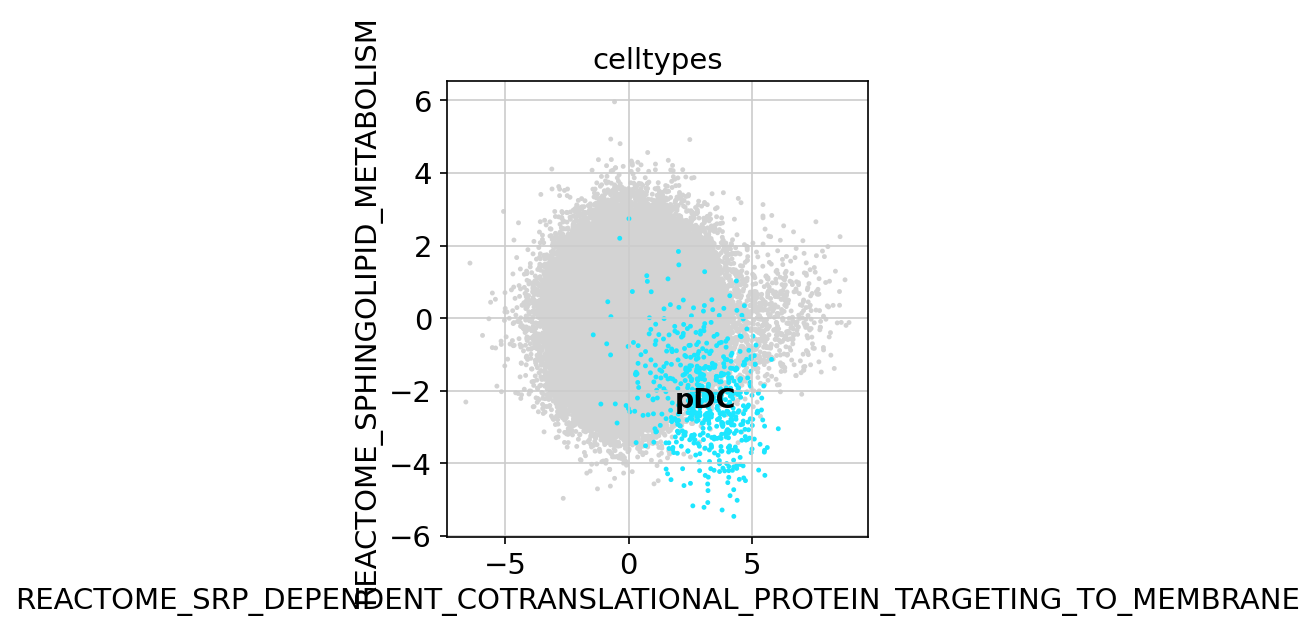

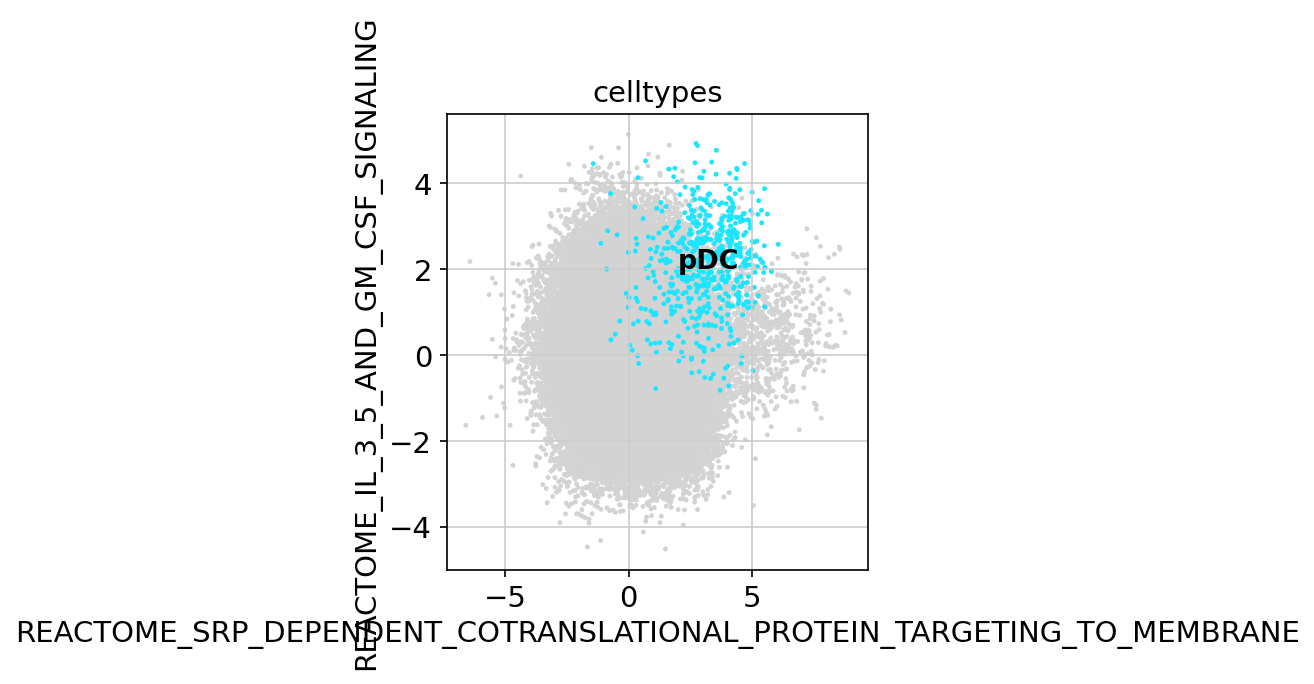

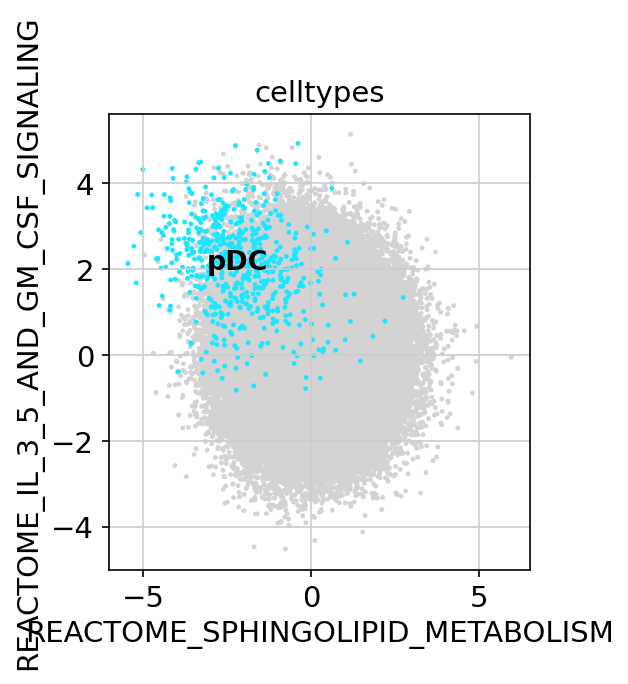

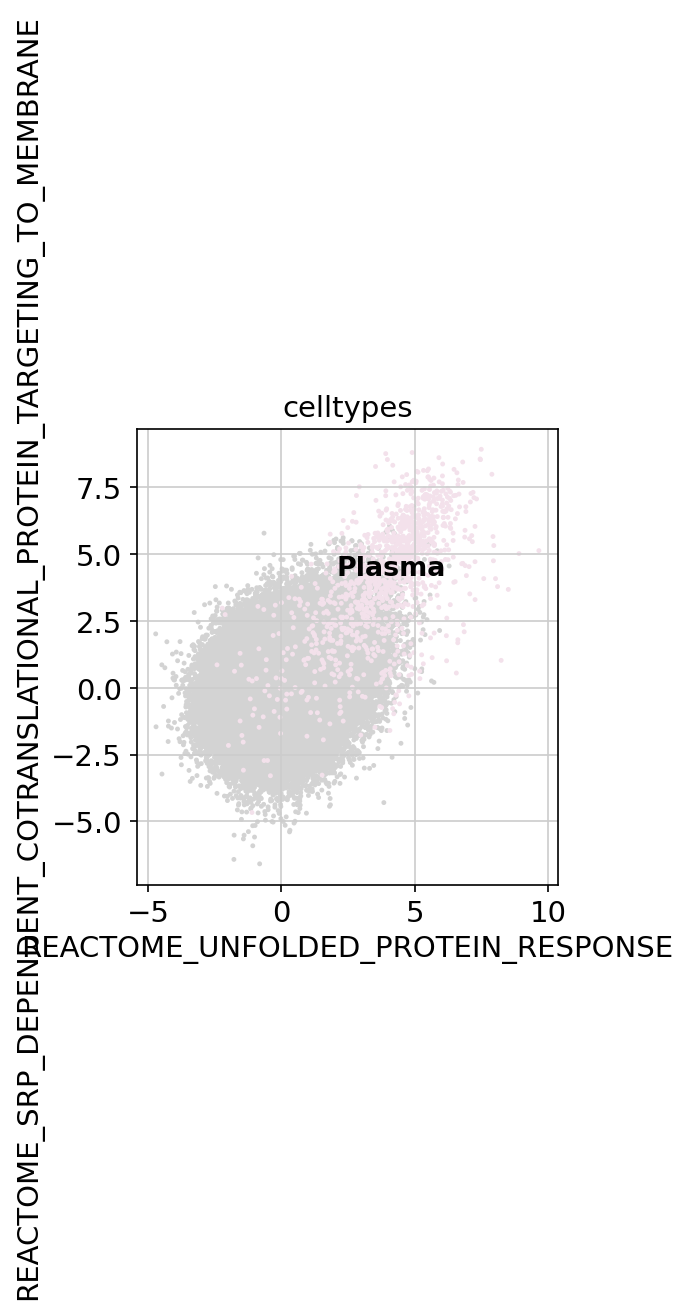

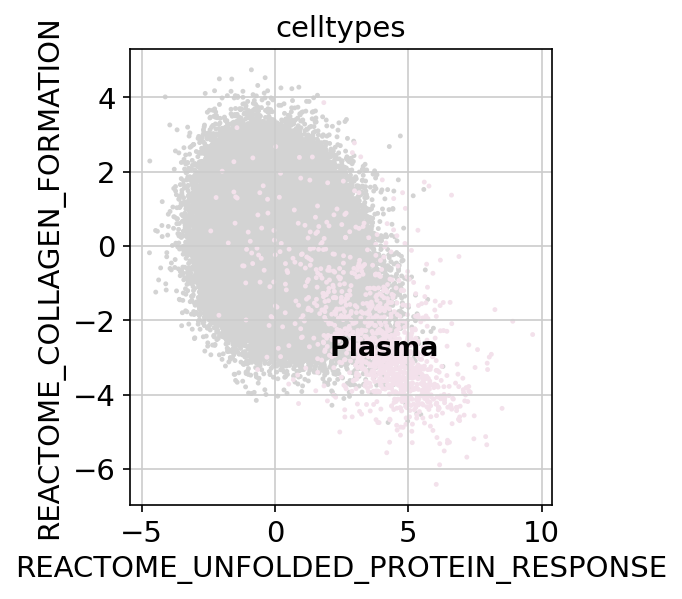

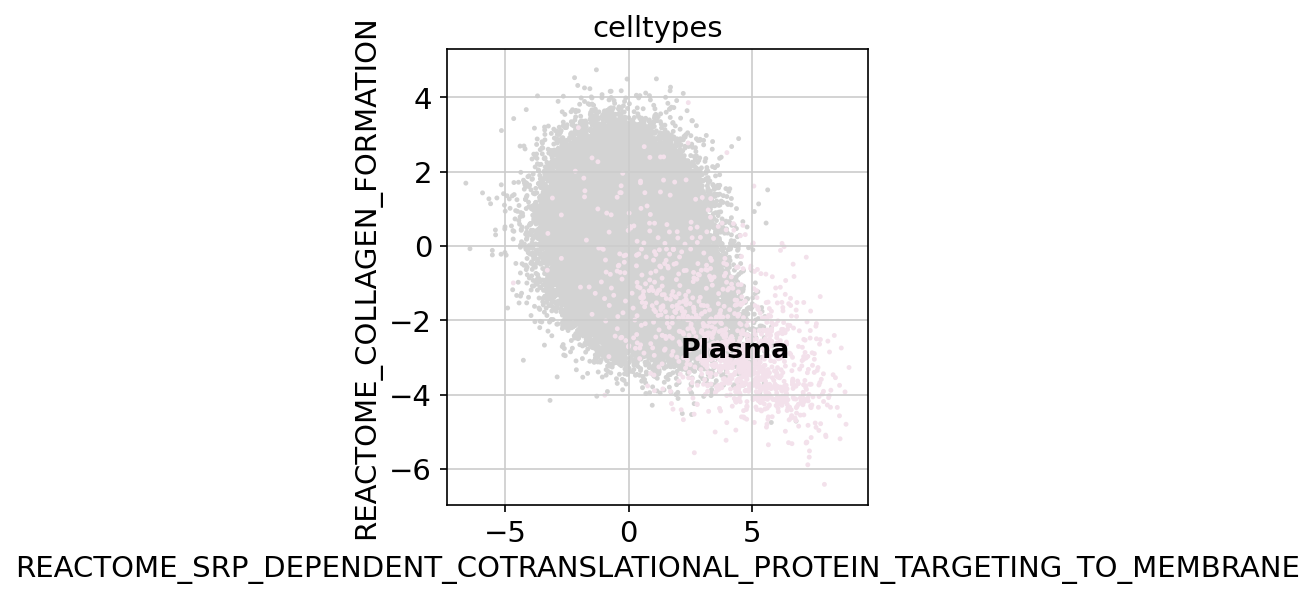

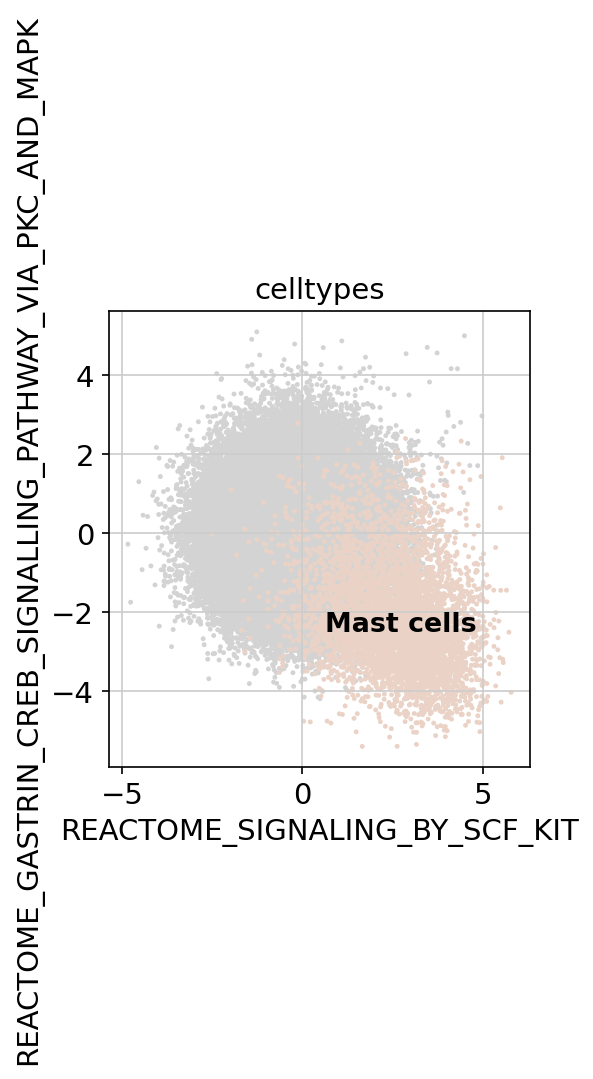

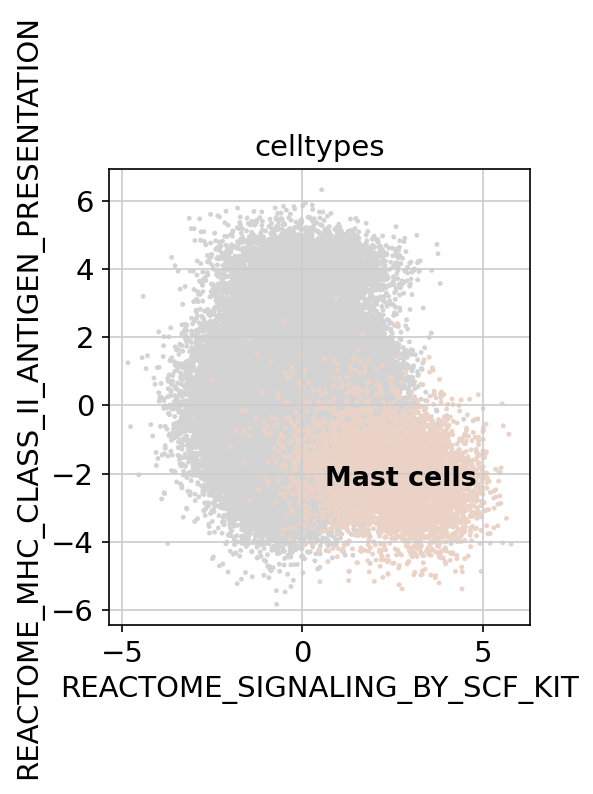

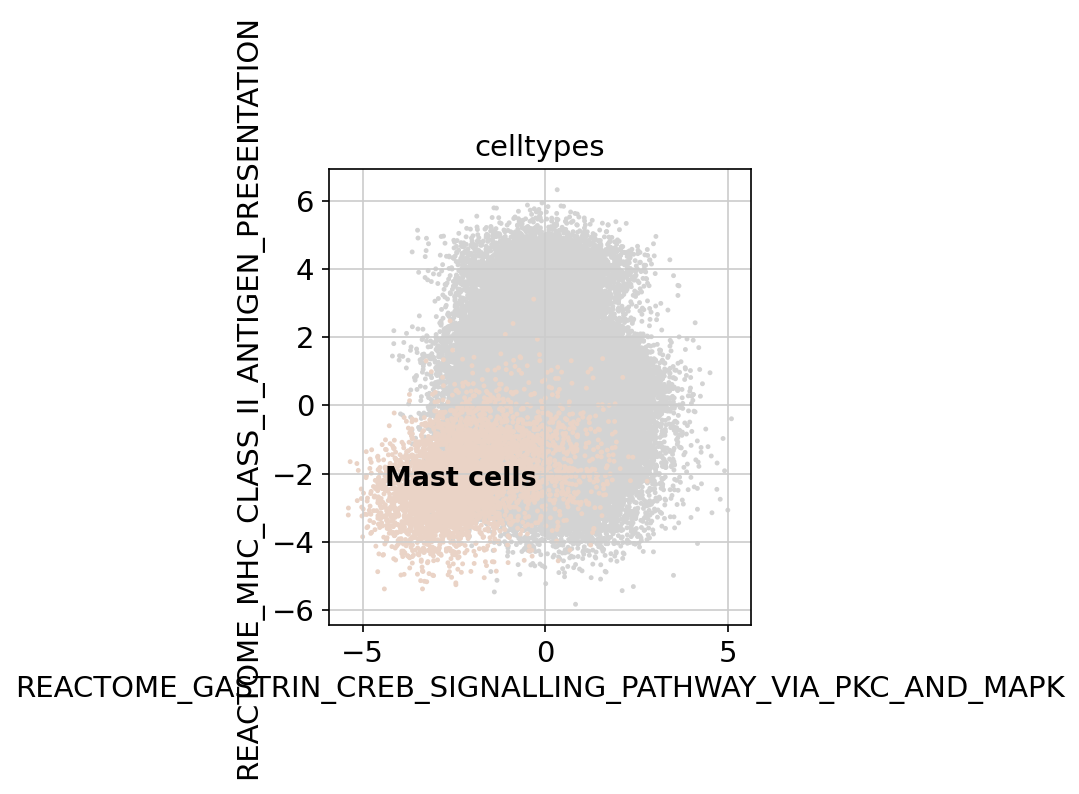

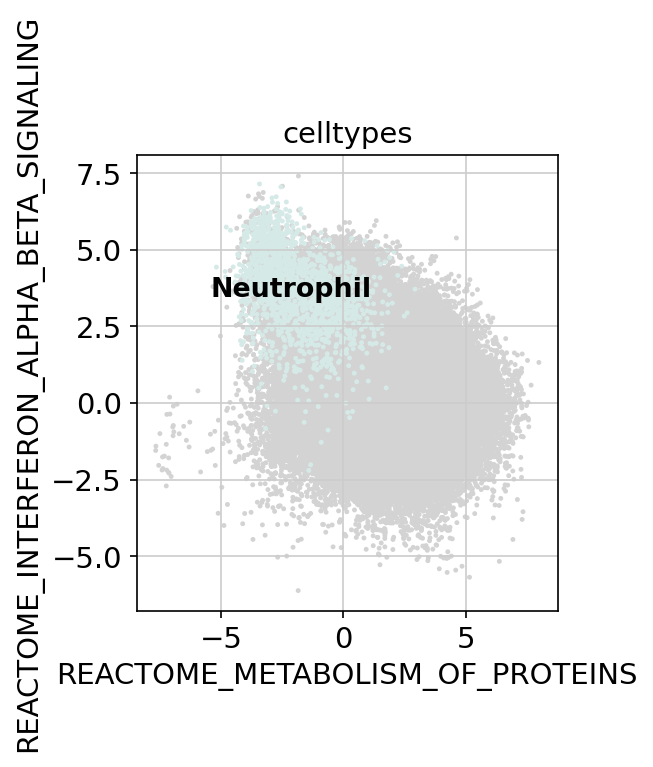

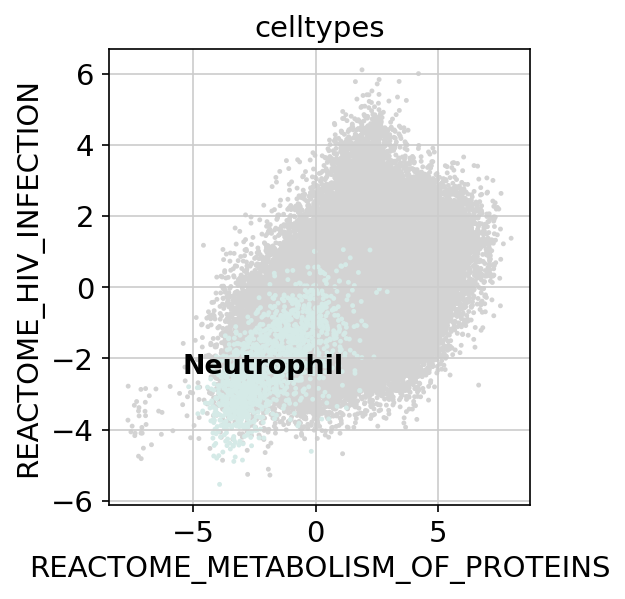

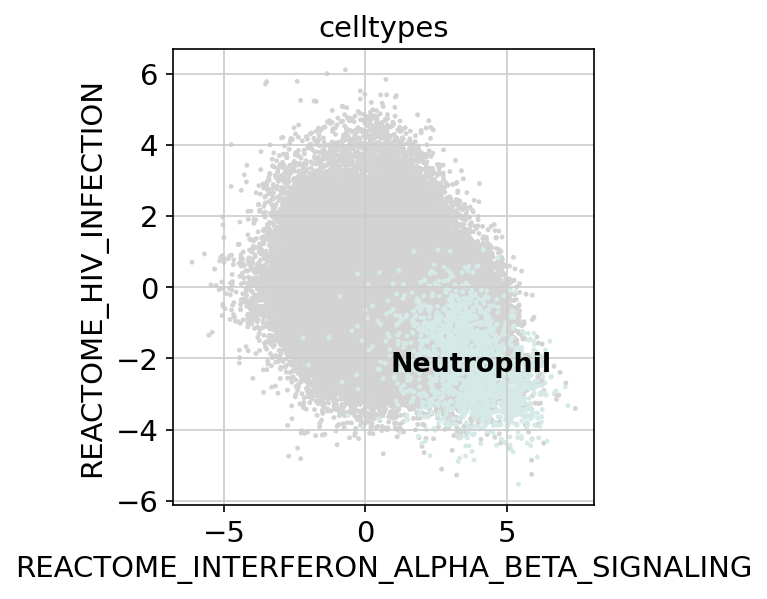

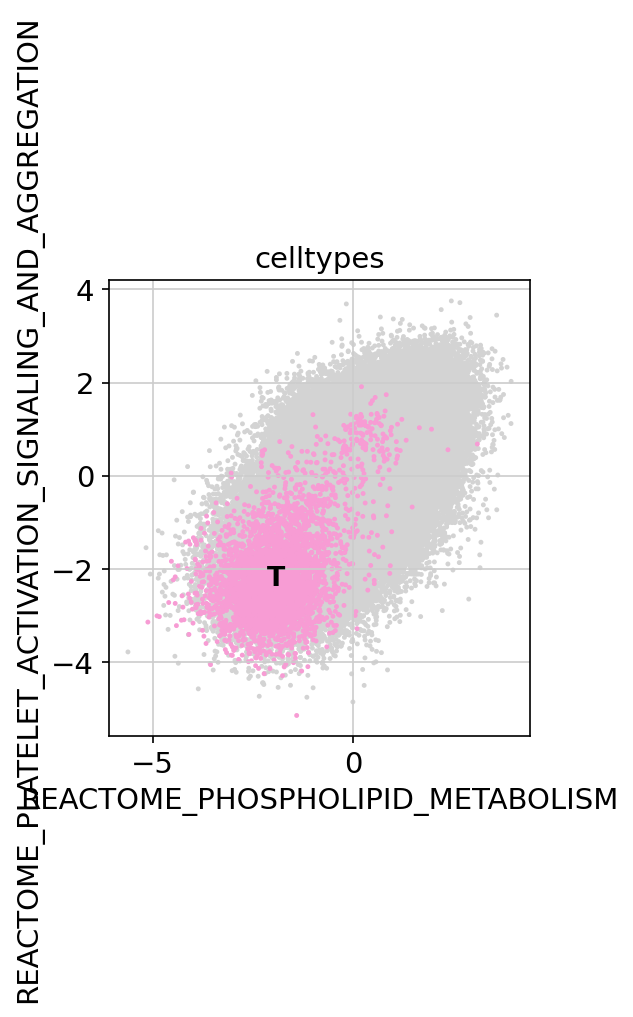

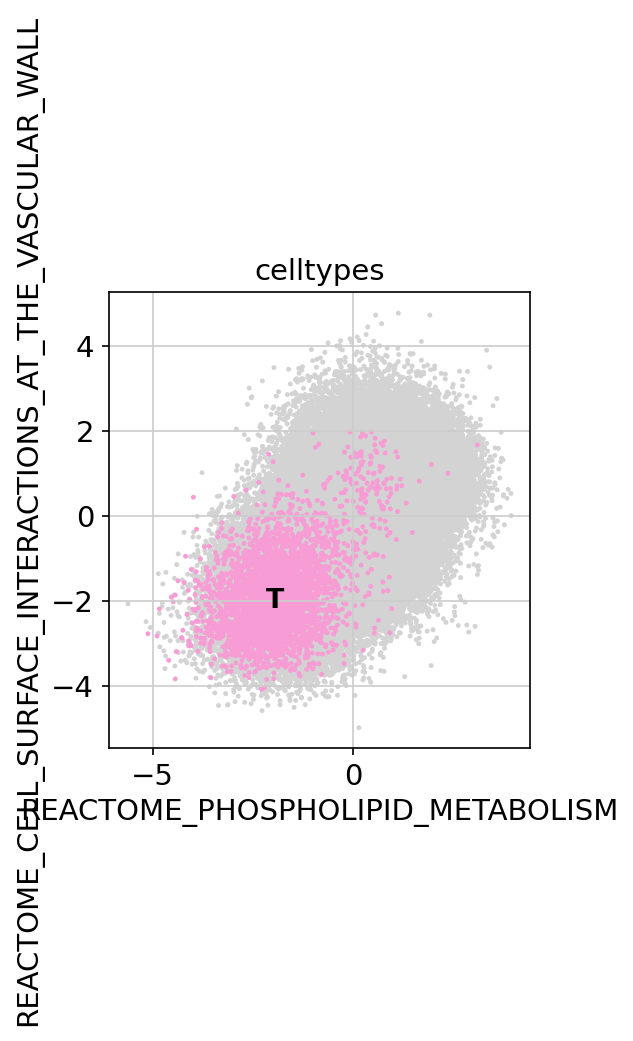

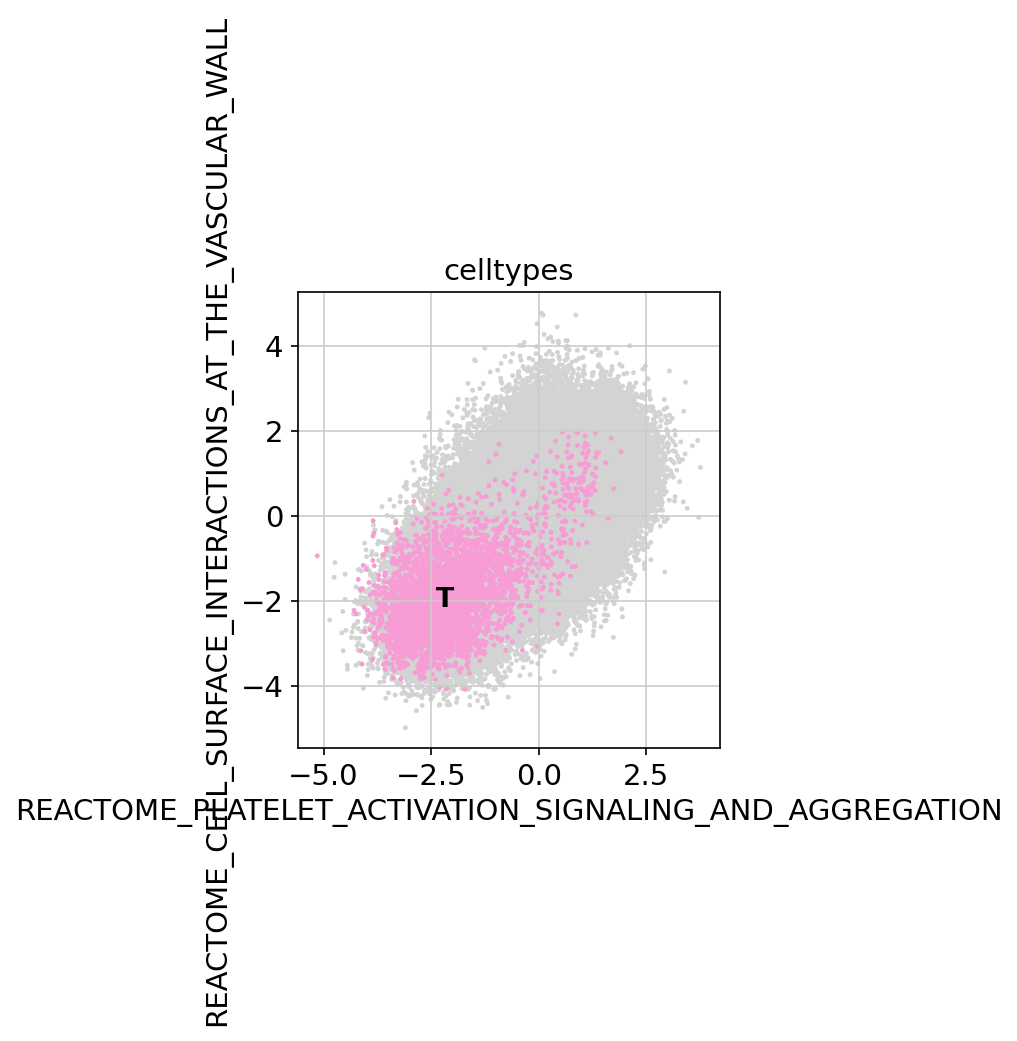

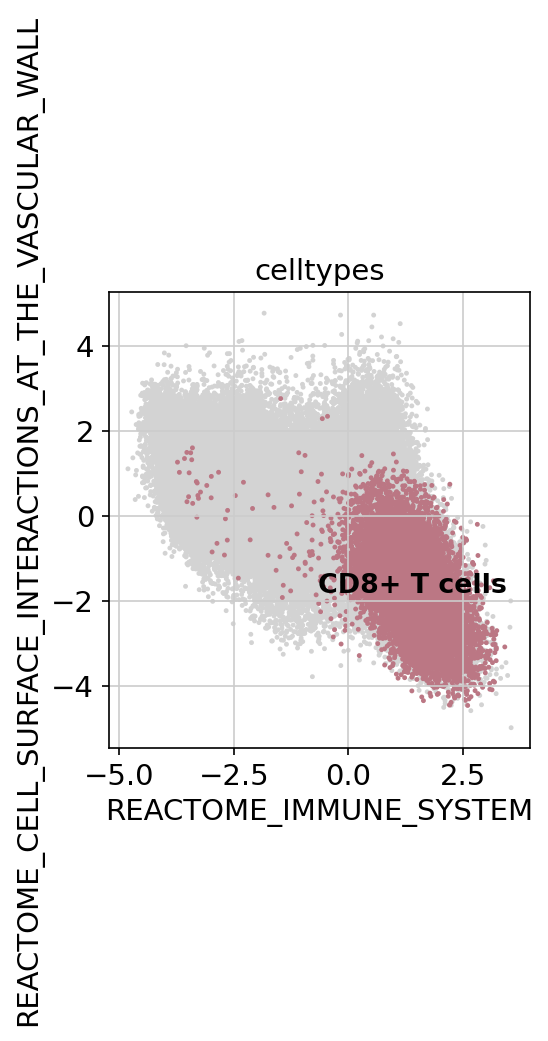

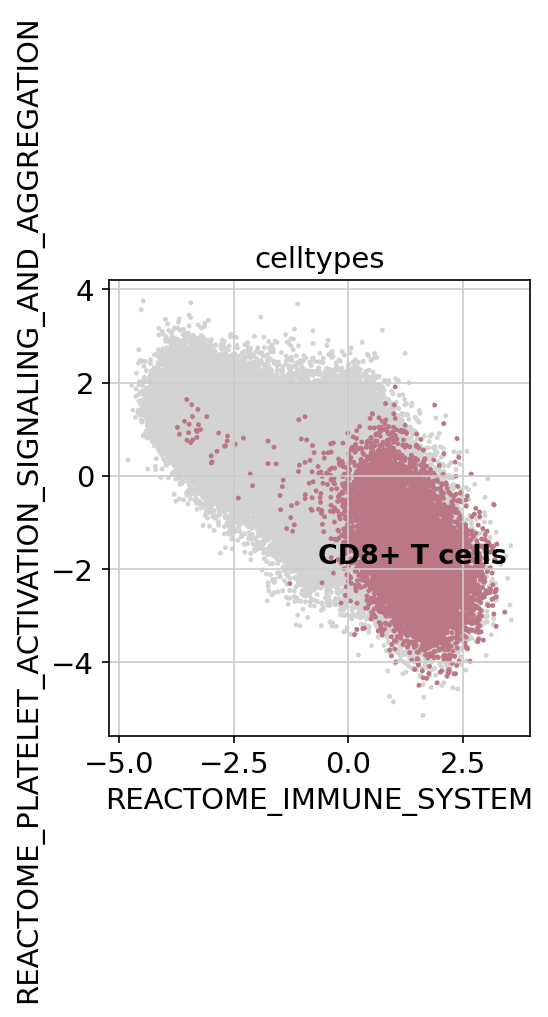

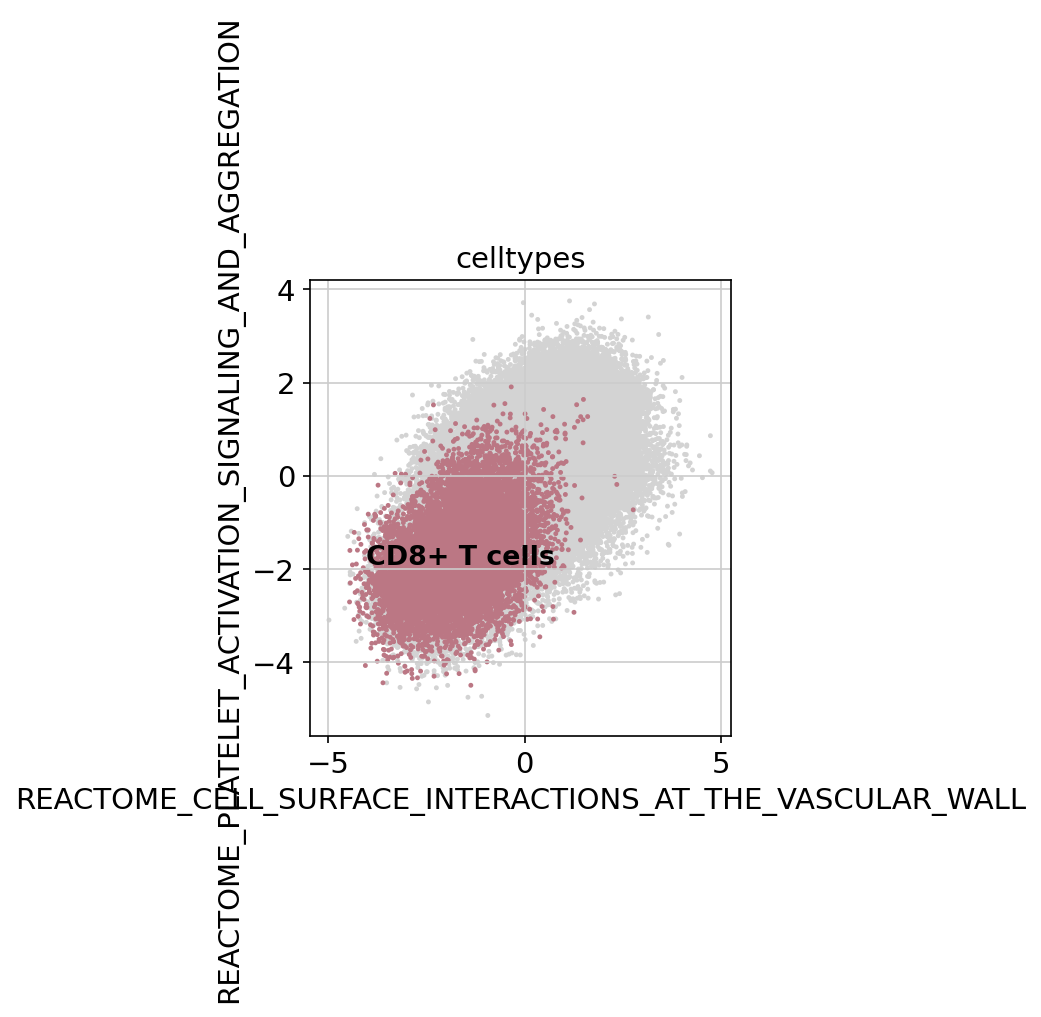

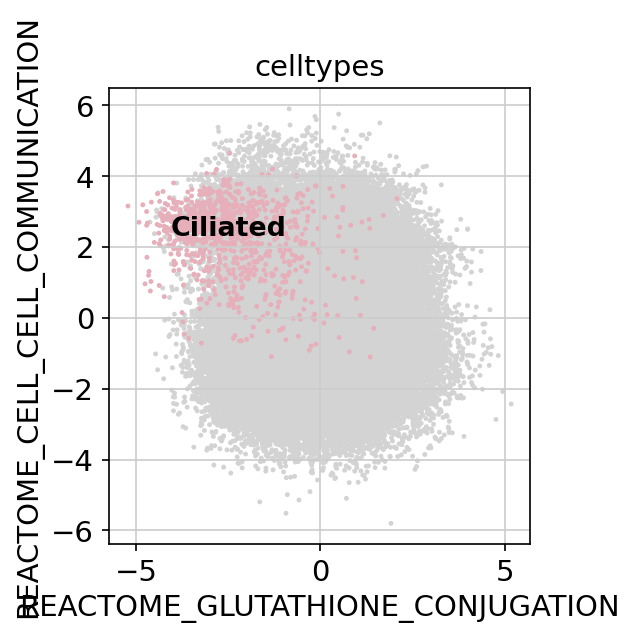

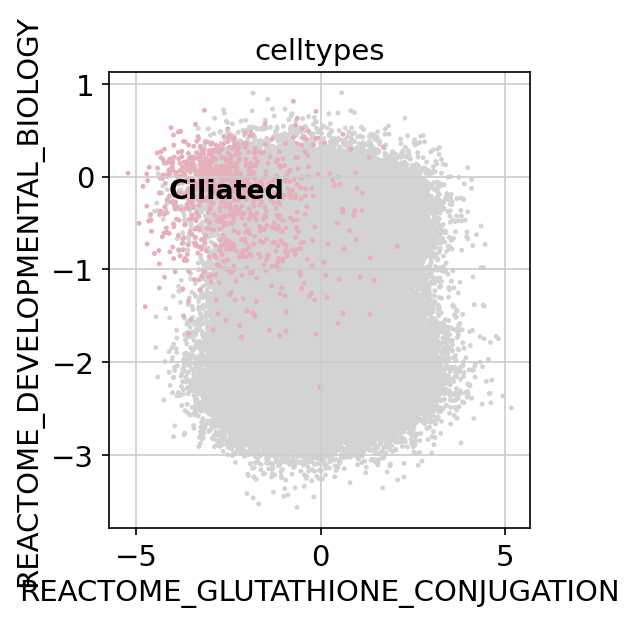

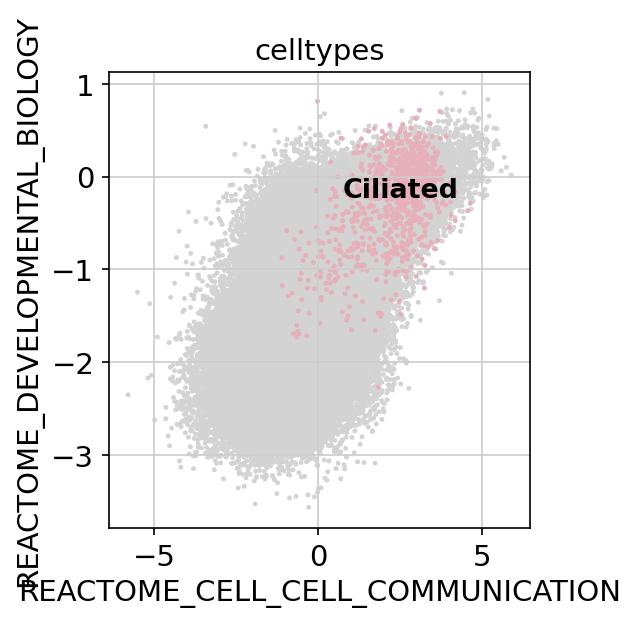

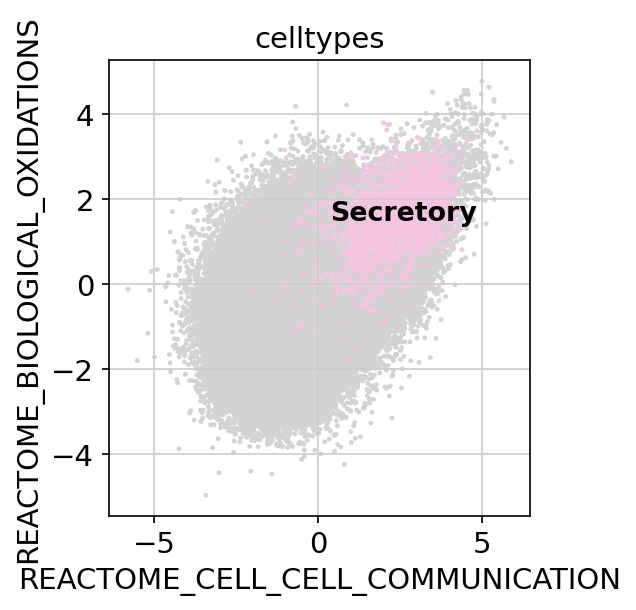

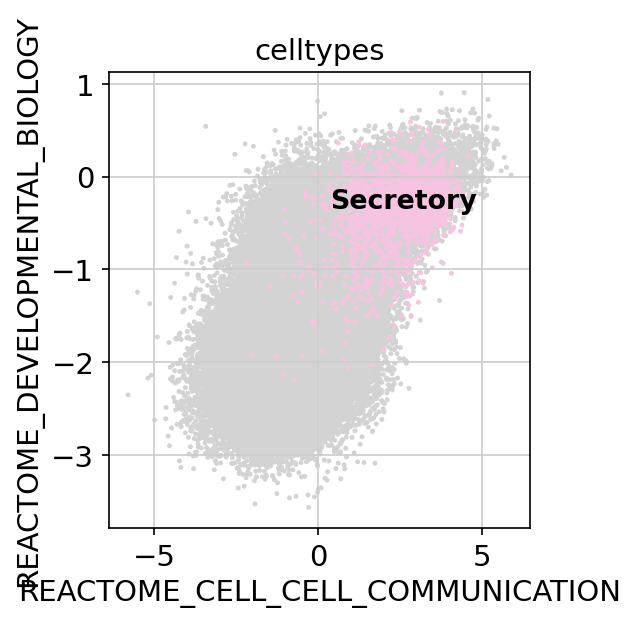

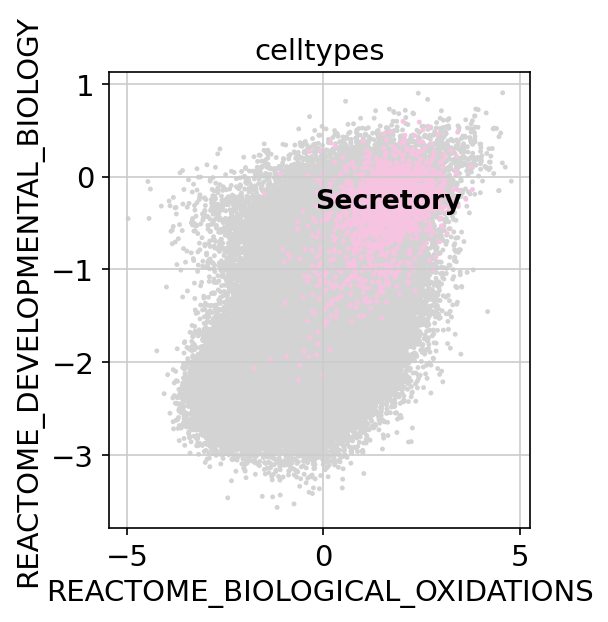

In [837]:
for ct in query.obs.celltype.unique():
    if(len(path_ways_ct[ct]))<1:
        continue
    if len(path_ways_ct[ct]["terms"]) >=2:
        sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][1], 
              color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=True)
        if len(path_ways_ct[ct]["terms"]) >2:
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=True)
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][1], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=True)

embedding for all cell types in query an reference

In [838]:
for ct in path_ways_ct.keys():
    if(len(path_ways_ct[ct]))<1:
        continue
    if len(path_ways_ct[ct]["terms"]) >=2:
        sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][1], 
              color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=False, save=f"_{ct}_re+q_v1")
        if len(path_ways_ct[ct]["terms"]) >2:
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=False, save=f"_{ct}_re+q_v2")
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][1], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data", show=False, save=f"_{ct}_re+q_v3")

In [902]:
query.obs.celltype.value_counts()

Macrophages     48734
T                3717
CD8+ T cells     2771
Neutrophil       1607
Secretory        1267
NK               1113
Plasma           1041
mDC               941
Ciliated          881
B cell            198
pDC               148
Mast cells         51
Name: celltype, dtype: int64

In [ ]:
for ct in query.obs.celltype.unique():
    if(len(path_ways_ct[ct]))<1:
        continue
    if len(path_ways_ct[ct]["terms"]) >=2:
        print(path_ways_ct[ct])
        sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][1], 
              color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data")
        if len(path_ways_ct[ct]["terms"]) >2:
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][0], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data")
            sc.pl.scatter(adata_all, x=path_ways_ct[ct]["terms"][1], y=path_ways_ct[ct]["terms"][2], 
          color='celltype', size=22, title='celltypes', groups=f"{ct}", legend_loc="on data")

saving adata and raw 

In [73]:
sc.pp.normalize_total(adata_raw)
sc.pp.log1p(adata_raw)
adata_all.raw = adata_raw

In [74]:
new_idx = []
for i in adata_all.obs.index:
    new_idx.append(i[:-2])

In [75]:
adata_all.obs.index = new_idx

In [76]:
adata_raw  = adata_raw[adata_all.obs.index,:].copy()

In [136]:
adata_all.raw = adata_raw

In [143]:
a = ['anatomical_region',
 'anatomical_region_detailed',
 'donor',
 'study',
 'study2',
 'celltype',
 'condition',
 'sample_new',
 'mt_frac',
 'n_counts',
 'n_genes',
 'tissue',
 'condition2',
 'REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION',
 'REACTOME_ANTIGEN_ACTIVATES_B_CELL_RECEPTOR_LEADING_TO_GENERATION_OF_SECOND_MESSENGERS',
 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR',
 'REACTOME_TRANSMEMBRANE_TRANSPORT_OF_SMALL_MOLECULES',
 'REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS',
 'REACTOME_IMMUNE_SYSTEM',
 'REACTOME_DEVELOPMENTAL_BIOLOGY',
 'REACTOME_METABOLISM_OF_AMINO_ACIDS_AND_DERIVATIVES',
 'REACTOME_MEMBRANE_TRAFFICKING',
 'REACTOME_HEMOSTASIS',
 'REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE',
 'REACTOME_SPHINGOLIPID_METABOLISM',
 'REACTOME_IL_3_5_AND_GM_CSF_SIGNALING',
 'REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM',
 'REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS',
 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
 'REACTOME_GLYCEROPHOSPHOLIPID_BIOSYNTHESIS',
 'REACTOME_UNFOLDED_PROTEIN_RESPONSE',
 'REACTOME_COLLAGEN_FORMATION',
 'REACTOME_SIGNALING_BY_SCF_KIT',
 'REACTOME_GASTRIN_CREB_SIGNALLING_PATHWAY_VIA_PKC_AND_MAPK',
 'REACTOME_RESPONSE_TO_ELEVATED_PLATELET_CYTOSOLIC_CA2_',
 'REACTOME_PHASE1_FUNCTIONALIZATION_OF_COMPOUNDS',
 'REACTOME_AXON_GUIDANCE',
 'REACTOME_METABOLISM_OF_PROTEINS',
 'REACTOME_HIV_INFECTION',
 'REACTOME_INTERFERON_SIGNALING',
 'REACTOME_CIRCADIAN_CLOCK',
 'REACTOME_GPCR_DOWNSTREAM_SIGNALING',
 'REACTOME_PHOSPHOLIPID_METABOLISM',
 'REACTOME_PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION',
 'REACTOME_CELL_SURFACE_INTERACTIONS_AT_THE_VASCULAR_WALL',
 'REACTOME_CELL_CYCLE',
 'REACTOME_GPCR_LIGAND_BINDING',
 'REACTOME_SIGNALING_BY_GPCR',
 'REACTOME_GLUTATHIONE_CONJUGATION',
 'REACTOME_CELL_CELL_COMMUNICATION',
 'REACTOME_RECRUITMENT_OF_MITOTIC_CENTROSOME_PROTEINS_AND_COMPLEXES',
 'REACTOME_BIOLOGICAL_OXIDATIONS',
 'REACTOME_ADAPTIVE_IMMUNE_SYSTEM',
 'REACTOME_SIGNALING_BY_RHO_GTPASES',
 'REACTOME_APOPTOTIC_CLEAVAGE_OF_CELLULAR_PROTEINS',
 'REACTOME_SLC_MEDIATED_TRANSMEMBRANE_TRANSPORT',
 'REACTOME_METABOLISM_OF_VITAMINS_AND_COFACTORS',
 'REACTOME_METABOLISM_OF_NUCLEOTIDES',
 'REACTOME_POST_TRANSLATIONAL_PROTEIN_MODIFICATION',
 'REACTOME_PHASE_II_CONJUGATION',
 'REACTOME_METABOLISM_OF_RNA',
 'REACTOME_INNATE_IMMUNE_SYSTEM',
 'REACTOME_MUSCLE_CONTRACTION',
 'REACTOME_AMYLOIDS',
 'REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION',
 'REACTOME_FORMATION_OF_THE_TERNARY_COMPLEX_AND_SUBSEQUENTLY_THE_43S_COMPLEX',
 'REACTOME_TRANSLATION',
 'REACTOME_INFLUENZA_VIRAL_RNA_TRANSCRIPTION_AND_REPLICATION',
 'REACTOME_METABOLISM_OF_PORPHYRINS',
 'REACTOME_FACTORS_INVOLVED_IN_MEGAKARYOCYTE_DEVELOPMENT_AND_PLATELET_PRODUCTION',
 'REACTOME_PURINE_METABOLISM',
 'REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS',
 'REACTOME_ANTIGEN_PROCESSING_UBIQUITINATION_PROTEASOME_DEGRADATION',
 'REACTOME_PROCESSING_OF_CAPPED_INTRON_CONTAINING_PRE_MRNA',
 'REACTOME_TOLL_RECEPTOR_CASCADES',
 'REACTOME_APOPTOTIC_EXECUTION_PHASE',
 'REACTOME_CELL_CYCLE_MITOTIC',
 'REACTOME_MEIOSIS',
 'REACTOME_POTASSIUM_CHANNELS',
 'REACTOME_REGULATION_OF_MRNA_STABILITY_BY_PROTEINS_THAT_BIND_AU_RICH_ELEMENTS',
 'REACTOME_GLYCOSAMINOGLYCAN_METABOLISM',
 'REACTOME_MRNA_PROCESSING',
 'REACTOME_CLASS_I_MHC_MEDIATED_ANTIGEN_PROCESSING_PRESENTATION',
 'REACTOME_MITOCHONDRIAL_PROTEIN_IMPORT',
 'REACTOME_STRIATED_MUSCLE_CONTRACTION',
 'REACTOME_FORMATION_OF_TUBULIN_FOLDING_INTERMEDIATES_BY_CCT_TRIC',
 'REACTOME_TRANSFERRIN_ENDOCYTOSIS_AND_RECYCLING',
 'REACTOME_TRANSPORT_OF_INORGANIC_CATIONS_ANIONS_AND_AMINO_ACIDS_OLIGOPEPTIDES',
 'REACTOME_RNA_POL_I_RNA_POL_III_AND_MITOCHONDRIAL_TRANSCRIPTION',
 'REACTOME_GLUCOSE_TRANSPORT',
 'REACTOME_3_UTR_MEDIATED_TRANSLATIONAL_REGULATION',
 'REACTOME_SIGNALING_BY_TGF_BETA_RECEPTOR_COMPLEX']

In [144]:
save = adata_all.copy()

In [164]:
save.obs = save.obs[a].copy()

In [151]:
save.X = adata_all.X

In [ ]:
adata_new = sc.AnnData

In [163]:
a = [
 'donor',
 'study',
 'celltype',
 'condition',
 'tissue',
 'condition2',
 'REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION',
 'REACTOME_ANTIGEN_ACTIVATES_B_CELL_RECEPTOR_LEADING_TO_GENERATION_OF_SECOND_MESSENGERS',
 'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR',
 'REACTOME_TRANSMEMBRANE_TRANSPORT_OF_SMALL_MOLECULES',
 'REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS',
 'REACTOME_IMMUNE_SYSTEM',
 'REACTOME_DEVELOPMENTAL_BIOLOGY',
 'REACTOME_METABOLISM_OF_AMINO_ACIDS_AND_DERIVATIVES',
 'REACTOME_MEMBRANE_TRAFFICKING',
 'REACTOME_HEMOSTASIS',
 'REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE',
 'REACTOME_SPHINGOLIPID_METABOLISM',
 'REACTOME_IL_3_5_AND_GM_CSF_SIGNALING',
 'REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM',
 'REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS',
 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
 'REACTOME_GLYCEROPHOSPHOLIPID_BIOSYNTHESIS',
 'REACTOME_UNFOLDED_PROTEIN_RESPONSE',
 'REACTOME_COLLAGEN_FORMATION',
 'REACTOME_SIGNALING_BY_SCF_KIT',
 'REACTOME_GASTRIN_CREB_SIGNALLING_PATHWAY_VIA_PKC_AND_MAPK',
 'REACTOME_RESPONSE_TO_ELEVATED_PLATELET_CYTOSOLIC_CA2_',
 'REACTOME_PHASE1_FUNCTIONALIZATION_OF_COMPOUNDS',
 'REACTOME_AXON_GUIDANCE',
 'REACTOME_METABOLISM_OF_PROTEINS',
 'REACTOME_HIV_INFECTION',
 'REACTOME_INTERFERON_SIGNALING',
 'REACTOME_CIRCADIAN_CLOCK',
 'REACTOME_GPCR_DOWNSTREAM_SIGNALING',
 'REACTOME_PHOSPHOLIPID_METABOLISM',
 'REACTOME_PLATELET_ACTIVATION_SIGNALING_AND_AGGREGATION',
 'REACTOME_CELL_SURFACE_INTERACTIONS_AT_THE_VASCULAR_WALL',
 'REACTOME_CELL_CYCLE',
 'REACTOME_GPCR_LIGAND_BINDING',
 'REACTOME_SIGNALING_BY_GPCR',
 'REACTOME_GLUTATHIONE_CONJUGATION',
 'REACTOME_CELL_CELL_COMMUNICATION',
 'REACTOME_RECRUITMENT_OF_MITOTIC_CENTROSOME_PROTEINS_AND_COMPLEXES',
 'REACTOME_BIOLOGICAL_OXIDATIONS',
 'REACTOME_ADAPTIVE_IMMUNE_SYSTEM',
 'REACTOME_SIGNALING_BY_RHO_GTPASES',
 'REACTOME_APOPTOTIC_CLEAVAGE_OF_CELLULAR_PROTEINS',
 'REACTOME_SLC_MEDIATED_TRANSMEMBRANE_TRANSPORT',
 'REACTOME_METABOLISM_OF_VITAMINS_AND_COFACTORS',
 'REACTOME_METABOLISM_OF_NUCLEOTIDES',
 'REACTOME_POST_TRANSLATIONAL_PROTEIN_MODIFICATION',
 'REACTOME_PHASE_II_CONJUGATION',
 'REACTOME_METABOLISM_OF_RNA',
 'REACTOME_INNATE_IMMUNE_SYSTEM',
 'REACTOME_MUSCLE_CONTRACTION',
 'REACTOME_AMYLOIDS',
 'REACTOME_TRANSCRIPTIONAL_REGULATION_OF_WHITE_ADIPOCYTE_DIFFERENTIATION',
 'REACTOME_FORMATION_OF_THE_TERNARY_COMPLEX_AND_SUBSEQUENTLY_THE_43S_COMPLEX',
 'REACTOME_TRANSLATION',
 'REACTOME_INFLUENZA_VIRAL_RNA_TRANSCRIPTION_AND_REPLICATION',
 'REACTOME_METABOLISM_OF_PORPHYRINS',
 'REACTOME_FACTORS_INVOLVED_IN_MEGAKARYOCYTE_DEVELOPMENT_AND_PLATELET_PRODUCTION',
 'REACTOME_PURINE_METABOLISM',
 'REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS',
 'REACTOME_ANTIGEN_PROCESSING_UBIQUITINATION_PROTEASOME_DEGRADATION',
 'REACTOME_PROCESSING_OF_CAPPED_INTRON_CONTAINING_PRE_MRNA',
 'REACTOME_TOLL_RECEPTOR_CASCADES',
 'REACTOME_APOPTOTIC_EXECUTION_PHASE',
 'REACTOME_CELL_CYCLE_MITOTIC',
 'REACTOME_MEIOSIS',
 'REACTOME_POTASSIUM_CHANNELS',
 'REACTOME_REGULATION_OF_MRNA_STABILITY_BY_PROTEINS_THAT_BIND_AU_RICH_ELEMENTS',
 'REACTOME_GLYCOSAMINOGLYCAN_METABOLISM',
 'REACTOME_MRNA_PROCESSING',
 'REACTOME_CLASS_I_MHC_MEDIATED_ANTIGEN_PROCESSING_PRESENTATION',
 'REACTOME_MITOCHONDRIAL_PROTEIN_IMPORT',
 'REACTOME_STRIATED_MUSCLE_CONTRACTION',
 'REACTOME_FORMATION_OF_TUBULIN_FOLDING_INTERMEDIATES_BY_CCT_TRIC',
 'REACTOME_TRANSFERRIN_ENDOCYTOSIS_AND_RECYCLING',
 'REACTOME_TRANSPORT_OF_INORGANIC_CATIONS_ANIONS_AND_AMINO_ACIDS_OLIGOPEPTIDES',
 'REACTOME_RNA_POL_I_RNA_POL_III_AND_MITOCHONDRIAL_TRANSCRIPTION',
 'REACTOME_GLUCOSE_TRANSPORT',
 'REACTOME_3_UTR_MEDIATED_TRANSLATIONAL_REGULATION',
 'REACTOME_SIGNALING_BY_TGF_BETA_RECEPTOR_COMPLEX']

In [161]:
save.obs

Index(['anatomical_region', 'anatomical_region_detailed', 'donor', 'study',
       'study2', 'celltype', 'condition', 'sample_new', 'mt_frac', 'n_counts',
       'n_genes', 'tissue', 'condition2',
       'REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION',
       'REACTOME_ANTIGEN_ACTIVATES_B_CELL_RECEPTOR_LEADING_TO_GENERATION_OF_SECOND_MESSENGERS',
       'REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR',
       'REACTOME_TRANSMEMBRANE_TRANSPORT_OF_SMALL_MOLECULES',
       'REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS',
       'REACTOME_IMMUNE_SYSTEM', 'REACTOME_DEVELOPMENTAL_BIOLOGY',
       'REACTOME_METABOLISM_OF_AMINO_ACIDS_AND_DERIVATIVES',
       'REACTOME_MEMBRANE_TRAFFICKING', 'REACTOME_HEMOSTASIS',
       'REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE',
       'REACTOME_SPHINGOLIPID_METABOLISM',
       'REACTOME_IL_3_5_AND_GM_CSF_SIGNALING',
       'REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM',
       'REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS',
       'REACT

In [167]:
df= save.obs.copy()

In [178]:
save.obs["study"] = df.study.to_list()

In [179]:
save.obs["condition"]= df.condition.to_list()
save.obs["condition2"]= df.condition2.to_list()
save.obs["donor"]= df.donor.to_list()
save.obs["tissue"]= df.tissue.to_list()
save.obs["celltype"]= df.celltype.to_list()

In [180]:
save.write("intg_covid.h5ad")

... storing 'study' as categorical
... storing 'condition' as categorical
... storing 'condition2' as categorical
... storing 'donor' as categorical
... storing 'tissue' as categorical
... storing 'celltype' as categorical
